# Imports and Installs

In [ ]:
!pip install yfinance

In [ ]:
# read files shared via google-drive-link
# https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab

!pip uninstall gdown -y && pip install gdown
!gdown -V

Found existing installation: gdown 5.2.0
Uninstalling gdown-5.2.0:
  Successfully uninstalled gdown-5.2.0
gdown 5.2.0 at /usr/local/lib/python3.11/dist-packages


In [ ]:
# IMPORTS
import numpy as np
import pandas as pd

#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# measure time for ML HyperParams search
import time
from datetime import date

# ML models and utils
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# Disable SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

# 0) One DataFrame with Dummies


## 0.1) Read and truncate data (last 25 years from 2000), define variable sets


In [ ]:
# https://stackoverflow.com/questions/62759748/downloading-data-from-a-shared-google-drive-link-in-google-colab
!gdown https://drive.google.com/file/d/1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB/view?usp=sharing --fuzzy -O /content/


Downloading...
From (original): https://drive.google.com/uc?id=1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB
From (redirected): https://drive.google.com/uc?id=1mb0ae2M5AouSDlqcUnIwaHq7avwGNrmB&confirm=t&uuid=0d8ea991-d426-4fda-a4bf-8db454fad11c
To: /content/stocks_df_combined_2025_06_13.parquet.brotli
100% 130M/130M [00:01<00:00, 99.4MB/s]


In [ ]:
# full dataset for 33 stocks
df_full = pd.read_parquet("/content/stocks_df_combined_2025_06_13.parquet.brotli", )

In [ ]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230262 entries, 0 to 5700
Columns: 203 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(129), int32(64), int64(5), object(2)
memory usage: 302.2+ MB


In [ ]:
# growth indicators (but not future growth)
GROWTH = [g for g in df_full.keys() if (g.find('growth_')==0)&(g.find('future')<0)]
GROWTH

['growth_1d',
 'growth_3d',
 'growth_7d',
 'growth_30d',
 'growth_90d',
 'growth_365d',
 'growth_dax_1d',
 'growth_dax_3d',
 'growth_dax_7d',
 'growth_dax_30d',
 'growth_dax_90d',
 'growth_dax_365d',
 'growth_snp500_1d',
 'growth_snp500_3d',
 'growth_snp500_7d',
 'growth_snp500_30d',
 'growth_snp500_90d',
 'growth_snp500_365d',
 'growth_dji_1d',
 'growth_dji_3d',
 'growth_dji_7d',
 'growth_dji_30d',
 'growth_dji_90d',
 'growth_dji_365d',
 'growth_epi_1d',
 'growth_epi_3d',
 'growth_epi_7d',
 'growth_epi_30d',
 'growth_epi_90d',
 'growth_epi_365d',
 'growth_gold_1d',
 'growth_gold_3d',
 'growth_gold_7d',
 'growth_gold_30d',
 'growth_gold_90d',
 'growth_gold_365d',
 'growth_wti_oil_1d',
 'growth_wti_oil_3d',
 'growth_wti_oil_7d',
 'growth_wti_oil_30d',
 'growth_wti_oil_90d',
 'growth_wti_oil_365d',
 'growth_brent_oil_1d',
 'growth_brent_oil_3d',
 'growth_brent_oil_7d',
 'growth_brent_oil_30d',
 'growth_brent_oil_90d',
 'growth_brent_oil_365d',
 'growth_btc_usd_1d',
 'growth_btc_usd_3d',


In [ ]:
# leaving only Volume ==> generate ln(Volume)
OHLCV = ['Open','High','Low','Close','Close_x','Volume']

In [ ]:
CATEGORICAL = ['Month', 'Weekday', 'Ticker', 'ticker_type']

In [ ]:
# 2% median growth
df_full.growth_future_30d.describe()

,growth_future_30d
count,229272.000000
mean,1.026918
std,0.123401
min,0.246131
25%,0.961060
50%,1.022628
75%,1.086602
max,5.179689


In [ ]:
# 59% of data records have positive future growth>0
df_full.is_positive_growth_30d_future.mean()

np.float64(0.59490927725808)

In [ ]:
# moving to strong growth (54% -> ~ 32%):
df_full.growth_future_30d.quantile(0.68)

np.float64(1.0661373423117089)

In [ ]:
TO_PREDICT = [g for g in df_full.keys() if (g.find('future')>=0)]
TO_PREDICT

['growth_future_30d', 'is_positive_growth_30d_future']

In [ ]:
# MAIN GOAL HERE IS TO MAKE SURE THAT 'OTHER' list is empty - we should categorize all feautures
# dropping some features - artifacts from joins, CATEGORICAL (to be converted to dummies), OHLCV
# 'index_x', 'index_y', 'index','Adj Close_y'
TO_DROP = ['Year','Date', 'Quarter', 'index_x', 'index_y', 'index', 'Close_y'] + CATEGORICAL + OHLCV
TO_DROP

['Year',
 'Date',
 'Quarter',
 'index_x',
 'index_y',
 'index',
 'Close_y',
 'Month',
 'Weekday',
 'Ticker',
 'ticker_type',
 'Open',
 'High',
 'Low',
 'Close',
 'Close_x',
 'Volume']

In [ ]:
# let's define on more custom numerical features
# Add a small constant to avoid log(0)
df_full['ln_volume'] = df_full.Volume.apply(lambda x: np.log(x+ 1e-6))

In [ ]:
# define additional columns (DUMMIES) on Dividends or Stock Splits
df_full['is_div_payout'] = (df_full.Dividends>0).astype(int)
df_full['is_stock_split'] = (df_full['Stock Splits']>0).astype(int)

In [ ]:
# manually defined features
# 'Dividends' and 'Stock Splits' - absolute values of Divs and Splits.
# is_stock_split, is_div_payout - dummies on the dates when Divs and Splits are >0
CUSTOM_NUMERICAL = ['SMA10', 'SMA20', 'growing_moving_average', 'high_minus_low_relative','volatility', 'ln_volume', 'is_div_payout', 'is_stock_split', 'Dividends', 'Stock Splits']

In [ ]:
# All Supported Ta-lib indicators: https://github.com/TA-Lib/ta-lib-python/blob/master/docs/funcs.md

TECHNICAL_INDICATORS = ['adx', 'adxr', 'apo', 'aroon_1','aroon_2', 'aroonosc',
 'bop', 'cci', 'cmo','dx', 'macd', 'macdsignal', 'macdhist', 'macd_ext',
 'macdsignal_ext', 'macdhist_ext', 'macd_fix', 'macdsignal_fix',
 'macdhist_fix', 'mfi', 'minus_di', 'mom', 'plus_di', 'dm', 'ppo',
 'roc', 'rocp', 'rocr', 'rocr100', 'rsi', 'slowk', 'slowd', 'fastk',
 'fastd', 'fastk_rsi', 'fastd_rsi', 'trix', 'ultosc', 'willr',
 'ad', 'adosc', 'obv', 'atr', 'natr', 'ht_dcperiod', 'ht_dcphase',
 'ht_phasor_inphase', 'ht_phasor_quadrature', 'ht_sine_sine', 'ht_sine_leadsine',
 'ht_trendmod', 'avgprice', 'medprice', 'typprice', 'wclprice']

In [ ]:
TECHNICAL_PATTERNS = [g for g in df_full.keys() if g.find('cdl')>=0]
print(f'Technical patterns count = {len(TECHNICAL_PATTERNS)}, examples = {TECHNICAL_PATTERNS[0:5]}')

Technical patterns count = 61, examples = ['cdl2crows', 'cdl3blackrows', 'cdl3inside', 'cdl3linestrike', 'cdl3outside']


In [ ]:
MACRO = ['gdppot_us_yoy', 'gdppot_us_qoq', 'cpi_core_yoy', 'cpi_core_mom', 'FEDFUNDS',
 'DGS1', 'DGS5', 'DGS10']

In [ ]:
NUMERICAL = GROWTH + TECHNICAL_INDICATORS + TECHNICAL_PATTERNS + CUSTOM_NUMERICAL + MACRO

In [ ]:
# CHECK: NO OTHER INDICATORS LEFT
OTHER = [k for k in df_full.keys() if k not in OHLCV + CATEGORICAL + NUMERICAL + TO_DROP + TO_PREDICT]
OTHER

[]

In [ ]:
df_full.Ticker.nunique()

33

In [ ]:
# Non truncated stats
# tickers, min-max date, count of daily observations
df_full.groupby(['Ticker'])['Date'].agg(['min','max','count'])

,min,max,count
Ticker,,,
AAPL,1980-12-12,2025-06-13,11217
ACN,2001-07-19,2025-06-13,6012
AMZN,1997-05-15,2025-06-13,7065
ASML,1995-03-15,2025-06-13,7614
AVGO,2009-08-06,2025-06-13,3989
BHARTIARTL.NS,2002-07-01,2025-06-13,5698
BRK-B,1996-05-09,2025-06-13,7322
CDI.PA,1992-01-27,2025-06-13,8610
GOOG,2004-08-19,2025-06-13,5239


In [ ]:
# truncated df_full with 25 years of data (and defined growth variables)
df = df_full[df_full.Date>='2000-01-01']
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 206 entries, Open to is_stock_split
dtypes: datetime64[ns](3), float64(130), int32(64), int64(7), object(2)
memory usage: 256.1+ MB


In [ ]:
# Truncated info by ticker
df.groupby(['Ticker'])['Date'].agg(['min','max','count'])

,min,max,count
Ticker,,,
AAPL,2000-01-03,2025-06-13,6401
ACN,2001-07-19,2025-06-13,6012
AMZN,2000-01-03,2025-06-13,6401
ASML,2000-01-03,2025-06-13,6401
AVGO,2009-08-06,2025-06-13,3989
BHARTIARTL.NS,2002-07-01,2025-06-13,5698
BRK-B,2000-01-03,2025-06-13,6401
CDI.PA,2000-01-03,2025-06-13,6540
GOOG,2004-08-19,2025-06-13,5239


## 0.2) Dummies

In [ ]:
# dummy variables can't be generated from Date and numeric variables ==> convert to STRING (to define groups for Dummies)
df.loc[:,'Month'] = df.Month.dt.strftime('%B')
df.loc[:,'Weekday'] = df.Weekday.astype(str)

/tmp/ipython-input-2164722115.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['January' 'January' 'January' ... 'June' 'June' 'June']' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.loc[:,'Month'] = df.Month.dt.strftime('%B')
/tmp/ipython-input-2164722115.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['0' '1' '2' ... '2' '3' '4']' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[:,'Weekday'] = df.Weekday.astype(str)


### 0.2.2) Generate all dummies

In [ ]:
# what are the categorical features?
# SHOULD we remove Ticker from CATEGORICAL? To generalize it even more?
CATEGORICAL

['Month', 'Weekday', 'Ticker', 'ticker_type']

In [ ]:
# Generate dummy variables (no need for bool, let's have int32 instead)
dummy_variables = pd.get_dummies(df[CATEGORICAL], dtype='int32')

In [ ]:
# the list of dummies
dummy_variables.keys()

Index(['Month_April', 'Month_August', 'Month_December', 'Month_February',
       'Month_January', 'Month_July', 'Month_June', 'Month_March', 'Month_May',
       'Month_November', 'Month_October', 'Month_September', 'Weekday_0',
       'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5',
       'Weekday_6', 'Ticker_AAPL', 'Ticker_ACN', 'Ticker_AMZN', 'Ticker_ASML',
       'Ticker_AVGO', 'Ticker_BHARTIARTL.NS', 'Ticker_BRK-B', 'Ticker_CDI.PA',
       'Ticker_GOOG', 'Ticker_HDB', 'Ticker_HINDUNILVR.NS', 'Ticker_IBN',
       'Ticker_IDEXY', 'Ticker_INFY', 'Ticker_ITC.NS', 'Ticker_JPM',
       'Ticker_LICI.NS', 'Ticker_LLY', 'Ticker_LT.NS', 'Ticker_MC.PA',
       'Ticker_META', 'Ticker_MSFT', 'Ticker_NVDA', 'Ticker_NVO',
       'Ticker_OR.PA', 'Ticker_RELIANCE.NS', 'Ticker_RMS.PA', 'Ticker_SAP',
       'Ticker_SBIN.NS', 'Ticker_SIE.DE', 'Ticker_TCS.NS', 'Ticker_TTE',
       'Ticker_V', 'ticker_type_EU', 'ticker_type_INDIA', 'ticker_type_US'],
      dtype='object')

In [ ]:
# get dummies names in a list
DUMMIES = dummy_variables.keys().to_list()
DUMMIES

['Month_April',
 'Month_August',
 'Month_December',
 'Month_February',
 'Month_January',
 'Month_July',
 'Month_June',
 'Month_March',
 'Month_May',
 'Month_November',
 'Month_October',
 'Month_September',
 'Weekday_0',
 'Weekday_1',
 'Weekday_2',
 'Weekday_3',
 'Weekday_4',
 'Weekday_5',
 'Weekday_6',
 'Ticker_AAPL',
 'Ticker_ACN',
 'Ticker_AMZN',
 'Ticker_ASML',
 'Ticker_AVGO',
 'Ticker_BHARTIARTL.NS',
 'Ticker_BRK-B',
 'Ticker_CDI.PA',
 'Ticker_GOOG',
 'Ticker_HDB',
 'Ticker_HINDUNILVR.NS',
 'Ticker_IBN',
 'Ticker_IDEXY',
 'Ticker_INFY',
 'Ticker_ITC.NS',
 'Ticker_JPM',
 'Ticker_LICI.NS',
 'Ticker_LLY',
 'Ticker_LT.NS',
 'Ticker_MC.PA',
 'Ticker_META',
 'Ticker_MSFT',
 'Ticker_NVDA',
 'Ticker_NVO',
 'Ticker_OR.PA',
 'Ticker_RELIANCE.NS',
 'Ticker_RMS.PA',
 'Ticker_SAP',
 'Ticker_SBIN.NS',
 'Ticker_SIE.DE',
 'Ticker_TCS.NS',
 'Ticker_TTE',
 'Ticker_V',
 'ticker_type_EU',
 'ticker_type_INDIA',
 'ticker_type_US']

In [ ]:
len(DUMMIES)

55

In [ ]:
# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([df, dummy_variables], axis=1)

In [ ]:
df_with_dummies[NUMERICAL+DUMMIES].info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 243 entries, growth_1d to ticker_type_US
dtypes: float64(123), int32(117), int64(3)
memory usage: 271.4 MB


### 0.2.4) Temporal split

In [ ]:
def temporal_split(df, min_date, max_date, train_prop=0.7, val_prop=0.15, test_prop=0.15):
    """
    Splits a DataFrame into three buckets based on the temporal order of the 'Date' column.

    Args:
        df (DataFrame): The DataFrame to split.
        min_date (str or Timestamp): Minimum date in the DataFrame.
        max_date (str or Timestamp): Maximum date in the DataFrame.
        train_prop (float): Proportion of data for training set (default: 0.7).
        val_prop (float): Proportion of data for validation set (default: 0.15).
        test_prop (float): Proportion of data for test set (default: 0.15).

    Returns:
        DataFrame: The input DataFrame with a new column 'split' indicating the split for each row.
    """
    # Define the date intervals
    train_end = min_date + pd.Timedelta(days=(max_date - min_date).days * train_prop)
    val_end = train_end + pd.Timedelta(days=(max_date - min_date).days * val_prop)

    # Assign split labels based on date ranges
    split_labels = []
    for date in df['Date']:
        if date <= train_end:
            split_labels.append('train')
        elif date <= val_end:
            split_labels.append('validation')
        else:
            split_labels.append('test')

    # Add 'split' column to the DataFrame
    df['split'] = split_labels

    return df

In [ ]:
min_date_df = df_with_dummies.Date.min()
max_date_df = df_with_dummies.Date.max()

df_with_dummies = temporal_split(df_with_dummies,
                                 min_date = min_date_df,
                                 max_date = max_date_df)

In [ ]:
# the split is approximate!
  # as tickers can have a different history
df_with_dummies['split'].value_counts()/len(df_with_dummies)

,count
split,
train,0.676399
test,0.163758
validation,0.159843


In [ ]:
# remove the "segmentation" problem (warning message on df performance after many joins and data transformations)
new_df = df_with_dummies.copy()

In [ ]:
# EXACT DATES for the split:
# time split on train/validation/test: FIXED dates of split, approx. 70%, 15%, 15% split
new_df.groupby(['split'])['Date'].agg({'min','max','count'})

,count,min,max
split,,,
test,31408,2021-08-20,2025-06-13
train,129730,2000-01-03,2017-10-25
validation,30657,2017-10-26,2021-08-19


In [ ]:
# Full dataframe (transformed and truncated to 25 years)
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191795 entries, 3490 to 5700
Columns: 262 entries, Open to split
dtypes: datetime64[ns](2), float64(130), int32(118), int64(7), object(5)
memory usage: 298.5+ MB


In [ ]:
# check one record: it has abs. values, text, and numbers
new_df.head(1)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,Ticker_SAP,Ticker_SBIN.NS,Ticker_SIE.DE,Ticker_TCS.NS,Ticker_TTE,Ticker_V,ticker_type_EU,ticker_type_INDIA,ticker_type_US,split
3490,35.975752,36.358881,34.3283,35.726719,53228400.0,0.0,0.0,MSFT,2000,January,...,0,0,0,0,0,0,0,0,1,train


In [ ]:
# what do we try to predict
new_df[TO_PREDICT].head(1)

,growth_future_30d,is_positive_growth_30d_future
3490,0.845576,0


### 0.2.5 Define dataframes for Modeling (ML) and cleane them

In [ ]:
# Features to be used in predictions (incl. new dummies)
features_list = NUMERICAL+DUMMIES


# What we're trying to predict?
to_predict = 'is_positive_growth_30d_future'

train_df = new_df[new_df.split.isin(['train'])].copy(deep=True)
valid_df = new_df[new_df.split.isin(['validation'])].copy(deep=True)
train_valid_df = new_df[new_df.split.isin(['train','validation'])].copy(deep=True)
test_df =  new_df[new_df.split.isin(['test'])].copy(deep=True)

# ONLY numerical Separate features and target variable for training and testing sets
X_train = train_df[features_list+[to_predict]]
X_valid = valid_df[features_list+[to_predict]]
X_train_valid = train_valid_df[features_list+[to_predict]]
X_test = test_df[features_list+[to_predict]]

# this to be used for predictions and join to the original dataframe new_df
X_all =  new_df[features_list+[to_predict]].copy(deep=True)

print(f'length: X_train {X_train.shape},  X_validation {X_valid.shape}, X_test {X_test.shape}, X_train_valid = {X_train_valid.shape},  all combined: X_all {X_all.shape}')

length: X_train (129730, 244),  X_validation (30657, 244), X_test (31408, 244), X_train_valid = (160387, 244),  all combined: X_all (191795, 244)


In [ ]:
# Prepare a dataframe for ML:
  # +-inf to NaN, all NaNs to 0s
def clean_dataframe_from_inf_and_nan(df:pd.DataFrame):
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
  df.fillna(0, inplace=True)
  return df

In [ ]:
# Clean from +-inf and NaNs:

X_train = clean_dataframe_from_inf_and_nan(X_train)
X_valid = clean_dataframe_from_inf_and_nan(X_valid)
X_train_valid = clean_dataframe_from_inf_and_nan(X_train_valid)
X_test = clean_dataframe_from_inf_and_nan(X_test)
X_all = clean_dataframe_from_inf_and_nan(X_all)

In [ ]:
y_train = X_train[to_predict]
y_valid = X_valid[to_predict]
y_train_valid = X_train_valid[to_predict]
y_test = X_test[to_predict]
y_all =  X_all[to_predict]

# remove y_* from X_* dataframes
del X_train[to_predict]
del X_valid[to_predict]
del X_train_valid[to_predict]
del X_test[to_predict]
del X_all[to_predict]

# 1) Modeling

## 1.1) Manual 'rule of thumb' predictions

* (pred0) CCI>200 (binary, on technical indicator CCI)
* (pred1) growth_30d>1
* (pred2) (growth_30d>1) & (growth_snp500_30d>1)
* (pred3) (DGS10 <= 4) & (DGS5 <= 1)
* (pred4) (DGS10 > 4) & (FEDFUNDS <= 4.795)

In [ ]:
# generate manual predictions
# Let's label all prediction features with prefix "pred"
new_df['pred0_manual_cci'] = (new_df.cci>200).astype(int)
new_df['pred1_manual_prev_g1'] = (new_df.growth_30d>1).astype(int)
new_df['pred2_manual_prev_g1_and_snp'] = ((new_df['growth_30d'] > 1) & (new_df['growth_snp500_30d'] > 1)).astype(int)
new_df['pred3_manual_dgs10_5'] = ((new_df['DGS10'] <= 4) & (new_df['DGS5'] <= 1)).astype(int)
new_df['pred4_manual_dgs10_fedfunds'] = ((new_df['DGS10'] > 4) & (new_df['FEDFUNDS'] <= 4.795)).astype(int)

In [ ]:
# example output manual predictions:
new_df[['cci','growth_30d','growth_snp500_30d','pred0_manual_cci','pred1_manual_prev_g1','pred2_manual_prev_g1_and_snp','pred3_manual_dgs10_5','pred4_manual_dgs10_fedfunds','is_positive_growth_30d_future']].sample(10)

,cci,growth_30d,growth_snp500_30d,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_dgs10_5,pred4_manual_dgs10_fedfunds,is_positive_growth_30d_future
4035,103.525796,1.022894,1.015006,0,1,1,0,0,1
6382,-167.543759,0.809016,0.877821,0,0,0,0,0,0
6658,263.578937,1.085629,1.032333,1,1,1,0,0,1
5726,-77.663473,0.827255,0.979974,0,0,0,0,0,0
4039,66.236480,0.920891,0.945084,0,0,0,0,0,1
1820,-56.407432,1.036578,1.028317,0,1,1,0,0,1
756,95.896148,1.051336,0.996473,0,1,0,0,1,0
2887,97.626731,1.027345,1.044059,0,1,1,1,0,1
5551,-67.286680,0.844195,0.967798,0,0,0,0,0,1
4686,68.065112,1.014642,0.982184,0,1,0,0,0,1


In [ ]:
# List of current predictions
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds']

In [ ]:
# Function to find all predictions (starting from 'pred'), generate is_correct (correctness of each prediction)
# and precision on TEST dataset (assuming there is df["split"] column with values 'train','validation','test'

# returns 2 lists of features: PREDICTIONS and IS_CORRECT

def get_predictions_correctness(df:pd.DataFrame, to_predict:str):
  PREDICTIONS = [k for k in df.keys() if k.startswith('pred')]
  print(f'Prediction columns founded: {PREDICTIONS}')

  # add columns is_correct_
  for pred in PREDICTIONS:
    part1 = pred.split('_')[0] # first prefix before '_'
    df[f'is_correct_{part1}'] =  (new_df[pred] == new_df[to_predict]).astype(int)

  # IS_CORRECT features set
  IS_CORRECT =  [k for k in df.keys() if k.startswith('is_correct_')]
  print(f'Created columns is_correct: {IS_CORRECT}')

  print('Precision on TEST set for each prediction:')
  # define "Precision" for ALL predictions on a Test dataset (~4 last years of trading)
  for i,column in enumerate(IS_CORRECT):
    prediction_column = PREDICTIONS[i]
    is_correct_column = column
    filter = (new_df.split=='test') & (new_df[prediction_column]==1)
    print(f'Prediction column:{prediction_column} , is_correct_column: {is_correct_column}')
    print(new_df[filter][is_correct_column].value_counts())
    print(new_df[filter][is_correct_column].value_counts()/len(new_df[filter]))
    print('---------')

  return PREDICTIONS, IS_CORRECT

In [ ]:
# check the precision of currect predictions. to_predict = previously defined variable to predict
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict= to_predict)

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    443
0    351
Name: count, dtype: int64
is_correct_pred0
1    0.557935
0    0.442065
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    9748
0    8243
Name: count, dtype: int64
is_correct_pred1
1    0.541826
0    0.458174
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    6984
0    6383
Name: count, dtype: int64
is_correct_pred2
1    0.522481
0    0.477519
Name: count, dtype: float64
-------

In [ ]:
# SAMPLE: check predictions vs. is_correct vs. is_positive_growth variable
new_df[PREDICTIONS+IS_CORRECT+[to_predict]].sample(10)

,pred0_manual_cci,pred1_manual_prev_g1,pred2_manual_prev_g1_and_snp,pred3_manual_dgs10_5,pred4_manual_dgs10_fedfunds,is_correct_pred0,is_correct_pred1,is_correct_pred2,is_correct_pred3,is_correct_pred4,is_positive_growth_30d_future
1259,0,0,0,0,0,0,0,0,0,0,1
2584,0,0,0,0,0,0,0,0,0,0,1
5773,0,0,0,0,1,1,1,1,1,0,0
4028,0,1,1,0,0,1,0,0,1,1,0
4195,0,0,0,1,0,1,1,1,0,1,0
2348,0,0,0,0,0,0,0,0,0,0,1
8369,0,1,1,0,0,1,0,0,1,1,0
276,0,0,0,0,0,1,1,1,1,1,0
3701,0,1,0,0,0,1,0,1,1,1,0
8644,0,1,1,1,0,0,1,1,1,0,1


## 1.2) Decision Tree Classifier

### 1.2.1) Defining Functions to clean_df(), fit_decision_tree(), predict_decision_tree()
* here we discuss only the Decision Tree Classifier for binary predictions (and not the Regressor)

In [ ]:
# Estimation/fit function (using dataframe of features X and what to predict y) --> optimising total accuracy
# max_depth is hyperParameter
def fit_decision_tree(X, y, max_depth=20):
# Initialize the Decision Tree Classifier
  clf = DecisionTreeClassifier(max_depth=max_depth,
                               random_state=42)

  # Fit the classifier to the training data
  clf.fit(X, y)
  return clf, X.columns

In [ ]:
%%time
clf_10, train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=10)

CPU times: user 28.2 s, sys: 188 ms, total: 28.4 s
Wall time: 31.8 s


In [ ]:
# predict on a full dataset
y_pred_all = clf_10.predict(X_all)

In [ ]:
# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred5_clf_10'] = y_pred_all

In [ ]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict = to_predict)

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds', 'pred5_clf_10']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    443
0    351
Name: count, dtype: int64
is_correct_pred0
1    0.557935
0    0.442065
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    9748
0    8243
Name: count, dtype: int64
is_correct_pred1
1    0.541826
0    0.458174
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    6984
0    6383
Name: count, dtype: int64
is_correct_pred2
1    0.522481
0    0.477519

## 1.2.3 Hyperparams tuning for a Decision Tree Classifier

In [ ]:
# visualisation: decision tree for a few levels (max_depth variable)
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# https://stackoverflow.com/questions/20156951/how-do-i-find-which-attributes-my-tree-splits-on-when-using-scikit-learn
from sklearn.tree import export_text

In [ ]:
# (8min runtime) UNCOMMENT TO RUN IT AGAIN
# %%time
# # hyper params tuning for a Decision Tree

# precision_by_depth = {}
# best_precision = 0
# best_depth = 0

# for depth in range(1,21):
#   print(f'Working with a tree of a max depth= {depth}')
#   # fitting the tree on X_train, y_train
#   clf,train_columns = fit_decision_tree(X=X_train_valid,
#                            y=y_train_valid,
#                            max_depth=depth) #applying custom hyperparam
#   # getting the predictions for TEST and accuracy score
#   y_pred_valid = clf.predict(X_valid)
#   precision_valid = precision_score(y_valid, y_pred_valid)
#   y_pred_test = clf.predict(X_test)
#   precision_test = precision_score(y_test, y_pred_test)
#   print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')
#   # saving to the dict
#   precision_by_depth[depth] = round(precision_test,4)
#   # updating the best precision
#   if precision_test >= best_precision:
#     best_precision = round(precision_test,4)
#     best_depth = depth
#   # plot tree - long
#   # plt.figure(figsize=(20,10))  # Set the size of the figure
#   # plot_tree(clf,
#   #           filled=True,
#   #           feature_names=train_columns,
#   #           class_names=['Negative', 'Positive'],
#   #           max_depth=2)
#   # plt.show()
#   # plot tree - short
#   tree_rules = export_text(clf, feature_names=list(X_train), max_depth=3)
#   print(tree_rules)
#   print('------------------------------')

# print(f'All precisions by depth: {precision_by_depth}')
# print(f'The best precision is {best_precision} and the best depth is {best_depth} ')

In [ ]:
# Results of Hyper parameters tuning for a Decision Tree
# print(precision_by_depth)

In [ ]:
# pre-calculated results of Hyperparameter tuning: full dataset (300 features) and is_positive_growth_5d
precision_by_depth = {1: 0.5466, 2: 0.5511, 3: 0.5511, 4: 0.5511, 5: 0.6278, 6: 0.5691, 7: 0.5945, 8: 0.5891, 9: 0.5912, 10: 0.5888, 11: 0.5916, 12: 0.5855, 13: 0.5822, 14: 0.592, 15: 0.5833, 16: 0.5898, 17: 0.586, 18: 0.5861, 19: 0.5869, 20: 0.5773}


In [ ]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame(list(precision_by_depth.items()), columns=['max_depth', 'precision_score'])
df.loc[:,'precision_score'] = df.precision_score*100.0 # need for % visualisation

# Create the bar chart using Plotly Express
fig = px.bar(df,
             x='max_depth',
             y='precision_score',
            #  title='Precision Score vs. Max Depth for a Decision Tree',
             labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score'},
             range_y=[54, 65],
             text='precision_score')

# Update the text format to display as percentages
fig.update_traces(texttemplate='%{text:.2f}%', textposition='outside')

# Center the title
fig.update_layout(title={'text': 'Precision Score vs. Max Depth for a Decision Tree', 'x': 0.5, 'xanchor': 'center'})


# Show the figure
fig.show()

In [ ]:
%%time
clf_5, train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=5)


# predict on a full dataset
y_pred_all = clf_5.predict(X_all)


# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred6_clf_5'] = y_pred_all

CPU times: user 15 s, sys: 218 ms, total: 15.2 s
Wall time: 15.2 s


In [ ]:
# MANUAL SECOND BEST, need some complexity for the threshhold rules
# found earlier in HyperParams Tuning
best_depth = 14
best_precision = precision_by_depth[best_depth]

In [ ]:
%%time
clf_best,train_columns = fit_decision_tree(X=X_train_valid,
                           y=y_train_valid,
                           max_depth=best_depth)

CPU times: user 35.9 s, sys: 135 ms, total: 36 s
Wall time: 36.1 s


In [ ]:
# For a DecisionTreeClassifier in scikit-learn, the concept of trainable parameters differs from that of neural networks.
# In decision trees, the parameters are the structure of the tree itself (nodes and splits) rather than weights.
# However, you can still get a sense of the model's complexity by looking at the number of nodes and leaves.

# Here's how you can get this information for your trained DecisionTreeClassifier (referred to as clf_best):

# Get the number of nodes and leaves in the tree
n_nodes = clf_best.tree_.node_count
n_leaves = clf_best.get_n_leaves()

print(f"Number of nodes: {n_nodes}")
print(f"Number of leaves: {n_leaves}")

Number of nodes: 4613
Number of leaves: 2307


In [ ]:
clf_best

DecisionTreeClassifier(max_depth=14, random_state=42)

In [ ]:
# predict on a full dataset
y_pred_clf_best = clf_best.predict(X_all)

In [ ]:
# defining a new prediction vector is easy now, as the dimensions will match
new_df['pred6_clf_best'] = y_pred_clf_best

In [ ]:
# new prediction is added --> need to recalculate the correctness
PREDICTIONS, IS_CORRECT = get_predictions_correctness(df = new_df, to_predict = to_predict)

Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds', 'pred5_clf_10', 'pred6_clf_5', 'pred6_clf_best']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    443
0    351
Name: count, dtype: int64
is_correct_pred0
1    0.557935
0    0.442065
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    9748
0    8243
Name: count, dtype: int64
is_correct_pred1
1    0.541826
0    0.458174
Name: count, dtype: float64
---------
Prediction column:pred2_manual_prev_g1_and_snp , is_correct_column: is_correct_pred2
is_correct_pred2
1    6984
0    6383
Name: count, dtyp

## 1.3) Random Forest
https://scikit-learn.org/stable/modules/ensemble.html#random-forests-and-other-randomized-tree-ensembles

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import time

# (12 min runtime FOR v28 machine) UNCOMMENT BELOW TO RUN HYPERPARAMs optimisation again

In [ ]:
# %%time
# # hyper params tuning

# precision_matrix = {}
# best_precision = 0
# best_depth = 0
# best_estimators = 1

# for depth in [5, 7, 9, 11, 13, 15, 17, 19]:
#   for estimators in [10,50,100,200]:
#     print(f'Working with HyperParams: depth = {depth}, estimators = {estimators}')

#     # Start timing
#     start_time = time.time()
#     # fitting the tree on X_train, y_train
#     rf = RandomForestClassifier(n_estimators = estimators,
#                                 max_depth = depth,
#                                 random_state = 42,
#                                 n_jobs = -1)

#     rf = rf.fit(X_train_valid, y_train_valid)

#     # getting the predictions for TEST and accuracy score
#     y_pred_valid = rf.predict(X_valid)
#     precision_valid = precision_score(y_valid, y_pred_valid)
#     y_pred_test = rf.predict(X_test)
#     precision_test = precision_score(y_test, y_pred_test)
#     print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')

#     # saving to the dict
#     precision_matrix[depth, estimators] = round(precision_test,4)

#     # Measure elapsed time
#     elapsed_time = time.time() - start_time
#     print(f'Time for training: {elapsed_time:.2f} seconds, or {elapsed_time/60:.2f} minutes')

#     # updating the best precision
#     if precision_test >= best_precision:
#       best_precision = round(precision_test,4)
#       best_depth = depth
#       best_estimators = estimators
#       print(f'New best precision found for depth={depth}, estimators = {estimators}')

#     print('------------------------------')

# print(f'Matrix of precisions: {precision_matrix}')
# print(f'The best precision is {best_precision} and the best depth is {best_depth} ')

In [ ]:
# uncomment when you run the hyperparam tuning again
# print(precision_matrix)

In [ ]:
# pre-calculated best precision matrix (max_depth, n_estimators) for Random Forest
best_precision_matrix_random_forest = best_precision_matrix_random_forest = {
    (5, 10): 0.5498,
    (5, 50): 0.5511,
    (5, 100): 0.5511,
    (5, 200): 0.5511,
    (7, 10): 0.5540,
    (7, 50): 0.5492,
    (7, 100): 0.5495,
    (7, 200): 0.5515,
    (9, 10): 0.5411,
    (9, 50): 0.5461,
    (9, 100): 0.5507,
    (9, 200): 0.5517,
    (11, 10): 0.5623,
    (11, 50): 0.5559,
    (11, 100): 0.5565,
    (11, 200): 0.5521,
    (13, 10): 0.5510,
    (13, 50): 0.5591,
    (13, 100): 0.5614,
    (13, 200): 0.5575,
    (15, 10): 0.5596,
    (15, 50): 0.5592,
    (15, 100): 0.5585,
    (15, 200): 0.5505,
    (17, 10): 0.5538,
    (17, 50): 0.5543,
    (17, 100): 0.5510,
    (17, 200): 0.5493,
    (19, 10): 0.5611,
    (19, 50): 0.5559,
    (19, 100): 0.5599,
    (19, 200): 0.5544,
}

In [ ]:

# Convert data to DataFrame
df = pd.DataFrame.from_dict(best_precision_matrix_random_forest, orient='index', columns=['precision_score']).reset_index()

# Rename the columns for clarity
df.columns = ['max_depth_and_metric', 'precision_score']

# Separate the tuple into two columns
df[['max_depth', 'n_estimators']] = pd.DataFrame(df['max_depth_and_metric'].tolist(), index=df.index)

# Drop the combined column
df = df.drop(columns=['max_depth_and_metric'])

# Create line plot using Plotly Express
fig = px.line(df, x='max_depth', y='precision_score', color='n_estimators',
              labels={'max_depth': 'Max Depth', 'precision_score': 'Precision Score', 'n_estimators': 'Number of Estimators'},
              title='Random Forest Models: Precision Score vs. Max Depth for Different Number of Estimators')

# Adjust x-axis range
fig.update_xaxes(range=[5, 20])

# Show the figure
fig.show()

In [ ]:
# MANUALLY SELECTED BEST - should have enough complexity and smoothness (n_estimators)
rf_best_n_estimators = 50
# MANUALLY SELECTED BEST - should have enough complexity
rf_best_max_depth = 19

In [ ]:
%%time

#
# several minutes to compute (2 min)

rf_best = RandomForestClassifier(n_estimators = rf_best_n_estimators,
                                 max_depth = rf_best_max_depth,
                                 random_state = 42,
                                 n_jobs = -1)

rf_best = rf_best.fit(X_train_valid, y_train_valid)

CPU times: user 2min 2s, sys: 413 ms, total: 2min 2s
Wall time: 1min 10s


## 1.4 Logistic Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

There can be many reasons when Logistic Regression does not converge: https://forecastegy.com/posts/how-to-solve-logistic-regression-not-converging-in-scikit-learn/

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Large feature magnitudes can cause convergence issues. If you haven’t already, scale your data:
# (only for the Logistic regression, and maybe for the Neural Network)
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_valid_scaled = scaler.fit_transform(X_train_valid)
# X_valid_scaled = scaler.transform(X_valid)
# X_test_scaled = scaler.transform(X_test)

# precision_matrix = {}
# best_precision = 0
# best_C = 0
# best_iter = 0

# for c in [1, 0.1, 0.01]:
#   for iter in [50, 100, 200]:
#     print(f'Working with HyperParams: C = {c} (positive float, smaller = stronger regularization), max_iter={iter}')
#     # fitting the tree on X_train, y_train
#       # hyperParam C should be between 0 and 1
#     lr = LogisticRegression(C=c,
#                             random_state=42,
#                             max_iter=iter,
#                             solver='sag',
#                             n_jobs=-1)

#     lr = lr.fit(X_train_valid_scaled, y_train_valid)

#     # getting the predictions for TEST and accuracy score
#     y_pred_valid = lr.predict(X_valid_scaled)
#     precision_valid = precision_score(y_valid, y_pred_valid)
#     y_pred_test = lr.predict(X_test_scaled)
#     precision_test = precision_score(y_test, y_pred_test)
#     print(f'  Precision on test is {precision_test}, (precision on valid is {precision_valid} - tend to overfit)')
#     # saving to the dict
#     precision_matrix[(c,iter)] = round(precision_test,4)
#     # updating the best precision
#     if precision_test >= best_precision:
#       best_precision = round(precision_test,4)
#       best_C = c
#       best_iter = iter
#       print(f'New best precision found for C={c}')
#       print('------------------------------')

# print(f'Matrix of precisions: {precision_matrix}')
# print(f'The best precision is {best_precision} and the best C is {best_C}, best max_iter = {best_iter}  ')

In [ ]:
# UNCOMMENT TO SEE THE RESULTS OF THE RUN
# print(precision_matrix)

In [ ]:
# Params on C, iter
best_precision_matrix_logistic_regression = {(1, 50): 0.5551, (1, 100): 0.555, (1, 200): 0.555, (0.1, 50): 0.5551, (0.1, 100): 0.555, (0.1, 200): 0.555, (0.01, 50): 0.5551, (0.01, 100): 0.555, (0.01, 200): 0.555}


In [ ]:
list(best_precision_matrix_logistic_regression.items())[0]

((1, 50), 0.5551)

In [ ]:
# Visualise precision scores

# Prepare the data
rows = []
for key, value in list(best_precision_matrix_logistic_regression.items()):
    C, max_iter = key
    combination_label = f'C={C}, max_iter={max_iter}'
    rows.append({'Combination': combination_label, 'Precision': value})

df = pd.DataFrame(rows)
df.loc[:,'Precision'] = df.Precision*100.0 # need for % visualisation

# Create the bar chart
fig = px.bar(df,
             x='Combination',
             y='Precision',
             text='Precision'
             )

# Customize the layout for better readability
fig.update_layout(
    xaxis_title='Hyperparams combinations of <C, Max Iterations>',
    yaxis_title='Precision Score',
    xaxis_tickangle=-45,
    title={
        'text': 'Precision Scores for Various Logistic Regression Hyperparameter Combinations',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    }
)


# Update the text position
fig.update_traces(texttemplate='%{text:.2f}%',
                  textposition='inside',
                  textfont_color='white')

# Show the figure
fig.show()

## 1.5) ADVANCED: Deep Neural Network (DNN) and hyperparams tuning
* Tutorial from Tensorflow.org
* TowardsDataScience Hyperparameter Optimization with Keras
* Machine Learning Mastery tutorial with Keras Deep Learning

In [ ]:
# https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53


# Extended params set

# p = {'lr': [0.01, 0.03,0.1, 0.3,1,3,10],
#      'first_neuron': [0,16,32,64,128,256],
#      'second_neuron':[0,16,32,64,128,256],
#      'first_dropout':[0,0.2,0.3],
#      'second_dropout':[0,0.2,0.3],
#      'activation_first':['relu','sigmoid','linear'],
#      'activation_second':['relu','sigmoid','linear'],
#     #  'activation_first':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
#     #  'activation_second':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
#     #  'batch_size':(2,30,10),
#     #  'loss': ('mse','mae'),
#     #  'epochs':[150],
#     #  'shape': ['brick','long_funnel'],
#      'optimizer':['adam', 'nadam', 'rmaprop','sgd'],
#     #  'losses': [logcosh, binary_crossentropy],
#     #  'last_activation':[sigmoid]
#      }


# Reduced params set and available options
p = {'lr': [0.1],
     'first_neuron': [12,24,32,48,96, 128, 196, 256],
     'second_neuron':[12,24,32,48,96, 128, 196, 256],
     'first_dropout':[0.1],
     'second_dropout':[0.1],
     'activation_first':['relu','sigmoid','softplus','tanh'],
     'activation_second':['relu'],
    #  'activation_first':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
    #  'activation_second':('relu','elu','tanh','sigmoid','linear','softplus','selu', 'softsign','exponential'),
    #  'batch_size':(2,30,10),
    #  'loss': ('mse','mae'),
    #  'epochs':[150],
    #  'shape': ['brick','long_funnel'],
     'optimizer':['adam','nadam','sgd','rmaprop'],
    #  'losses': [logcosh, binary_crossentropy],
    #  'last_activation':[sigmoid]
     }


# Number of models to run and write to SHEETS:
count_models=0

nn_params = {}

for lr in p['lr']:
  for first_neuron in p['first_neuron']:
    for second_neuron in p['second_neuron']:
      for first_dropout in p['first_dropout']:
        for second_dropout in p['second_dropout']:
          for activation_first in p['activation_first']:
            for activation_second in p['activation_second']:
              for optimizer in p['optimizer']:
                # print(lr,first_neuron,second_neuron,first_dropout,second_dropout,activation_first,activation_second,optimizer,sep='/')
                count_models=count_models+1
                nn_params['learning_rate'] = lr
                nn_params['first_layer_neurons'] = first_neuron
                nn_params['first_layer_dropout'] = first_dropout
                nn_params['second_layer_neurons'] = second_neuron
                nn_params['second_layer_dropout'] = second_dropout
                nn_params['activation_first_layer'] = activation_first
                nn_params['activation_second_layer'] = activation_second
                nn_params['optimizer'] = optimizer
                # features count as an input shape
                nn_params['input_shape'] = len(X_train.keys())

# Current set of models to try
print(count_models)

1024


In [ ]:
# example of a Neural Network HyperParams setup
nn_params

{'learning_rate': 0.1,
 'first_layer_neurons': 256,
 'first_layer_dropout': 0.1,
 'second_layer_neurons': 256,
 'second_layer_dropout': 0.1,
 'activation_first_layer': 'tanh',
 'activation_second_layer': 'relu',
 'optimizer': 'rmaprop',
 'input_shape': 243}

In [ ]:
import tensorflow as tf
import keras
from keras import layers
# from keras.models import Sequential
# from keras.layers import Dense, Input, Dropout, Activation

In [ ]:
# building one Neural Network when Parameters are known:
import datetime

# len(rez_train.keys())
def build_model(nn_params):
  # lr, first_neuron, second_neuron, first_dropout, second_dropout, activation_first, activation_second, optimizer
  model = keras.Sequential([
  layers.Dense(nn_params['first_layer_neurons'],
               activation=nn_params['activation_first_layer'],
               input_shape=[nn_params['input_shape']]),
  layers.Dropout(nn_params['first_layer_dropout']),
  layers.Dense(nn_params['second_layer_neurons'],
               activation=nn_params['activation_second_layer']),
  layers.Dropout(nn_params['second_layer_dropout']),
  layers.Dense(1, activation='sigmoid') # sigmoid is important for a Neural Network
  ])

  if optimizer == 'adam':
    opt = keras.optimizers.Adam(lr)
  elif optimizer == 'nadam':
    opt = keras.optimizers.Nadam(lr)
  elif optimizer == 'rmsprop':
    opt = keras.optimizers.RMSprop(lr)
  elif optimizer == 'sgd':
    opt = keras.optimizers.SGD(lr)
  else:
    opt = keras.optimizers.Adagrad(lr)
  model.compile(loss='binary_crossentropy', # mae/rmse for the Regression,
                optimizer=opt,
                metrics=['accuracy',keras.metrics.Precision()]) # or use [keras.metrics.Precision()] for a binary model : https://keras.io/api/metrics/classification_metrics/#precision-class
  return model

In [ ]:
nn_params

{'learning_rate': 0.1,
 'first_layer_neurons': 256,
 'first_layer_dropout': 0.1,
 'second_layer_neurons': 256,
 'second_layer_dropout': 0.1,
 'activation_first_layer': 'tanh',
 'activation_second_layer': 'relu',
 'optimizer': 'rmaprop',
 'input_shape': 243}

In [ ]:
# construct a model based on those hyperparams
model = build_model(nn_params)
model.summary()
# model.get_config()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        62,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,513 (502.00 KB)

 Trainable params: 128,513 (502.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# trainable params in the model with max params (large hidden layers shape)
model.count_params()

128513

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print()
    print('.', end='')

In [ ]:
# read tutorial about Binary Classification with Neural Network
# https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit


# HYPER_PARAMS_SPACE = PARAMS space
# WHEN MAX_MODELS>0: return after MAX_MODELS checked
# MAX_EPOCHS: how many epochs (periods when model weights are updated) do we need?
def train_neural_network_with_hyperparams(HYPER_PARAMS_SPACE, MAX_MODELS=0, MAX_EPOCHS=250, EARLY_STOPPING_PATIENCE=20):

  # The patience parameter is the amount of epochs to check for improvement
  early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy',  # we want accuracy to improve every single iteration (or at least in several iterations (EARLY STOPPING PARAM))
                                             patience = EARLY_STOPPING_PATIENCE)
  nn_params = {} # current hyperParams settings
  cur = 0 # models trained

  # best stats
  best_accuracy = 0
  best_model = None
  best_history = None

  for lr in HYPER_PARAMS_SPACE['lr']:
    for first_dropout in HYPER_PARAMS_SPACE['first_dropout']:
      for second_dropout in HYPER_PARAMS_SPACE['second_dropout']:
        for activation_first in HYPER_PARAMS_SPACE['activation_first']:
          for activation_second in HYPER_PARAMS_SPACE['activation_second']:
            for optimizer in HYPER_PARAMS_SPACE['optimizer']:
              for first_neuron in HYPER_PARAMS_SPACE['first_neuron']:
                for second_neuron in HYPER_PARAMS_SPACE['second_neuron']:
                  cur = cur+1

                  nn_params['learning_rate'] = lr
                  nn_params['first_layer_neurons'] = first_neuron
                  nn_params['first_layer_dropout'] = first_dropout
                  nn_params['second_layer_neurons'] = second_neuron
                  nn_params['second_layer_dropout'] = second_dropout
                  nn_params['activation_first_layer'] = activation_first
                  nn_params['activation_second_layer'] = activation_second
                  nn_params['optimizer'] = optimizer

                  # features count as an input shape
                  nn_params['input_shape'] = len(X_train.keys())

                  print(f'Using HyperParams:{nn_params}')

                  model = build_model(nn_params)
                  # model.summary()

                  frame = pd.DataFrame(data=[cur,lr,first_neuron,second_neuron,first_dropout,second_dropout, activation_first, activation_second, optimizer])

                  print(f"Training model {cur} with trainable params {model.count_params()} :")
                  t_start = datetime.datetime.now()
                  history = model.fit(
                                        X_train_valid,
                                        y_train_valid,
                                        epochs=MAX_EPOCHS,
                                        validation_data = (X_test, y_test),
                                        verbose=1, #change to 0 if you don't want to see the progress
                                        callbacks=[early_stop,PrintDot()])

                  t_diff = datetime.datetime.now() - t_start
                  frame = pd.DataFrame(data=[t_diff.seconds,
                                          len(history.epoch),
                                          history.history['val_accuracy'][0], # start of learning
                                          history.history['val_accuracy'][len(history.epoch)-1], # end of learning
                                          #  history.history['val_precision_2'][0], # start of learning
                                          #  history.history['val_precision_2'][len(history.epoch)-1], # end of learning
                                          ])

                  if history.history['val_accuracy'][len(history.epoch)-1]> best_accuracy:
                    best_accuracy = history.history['val_accuracy'][len(history.epoch)-1]
                    best_model = model
                    best_history = history

                  # early stopping of hyper params loop
                  if MAX_MODELS>0 and cur>=MAX_MODELS:
                    return best_model, best_history.history

                  print('==============================================================')

  return best_model, best_history.history #full hyper params search on all models

In [ ]:
# returns best_model (trained) and best_history (history of train operations)
# best_model, best_history = train_neural_network_with_hyperparams(HYPER_PARAMS_SPACE=p,
#                                                                  MAX_MODELS=2, #not more than 2 models
#                                                                  MAX_EPOCHS=250,
#                                                                  EARLY_STOPPING_PATIENCE=10
#                                                                  )

In [ ]:
# UNCOMMENT TO RUN AGAIN

# best_history_nn = best_history
# best_model_nn = best_model

In [ ]:
# best_model_nn.summary()

In [ ]:
best_history_nn = {'loss': [208422.703125,
  1121.272705078125,
  539.65283203125,
  707.9421997070312,
  516.6778564453125,
  163.7510528564453,
  317.2767333984375,
  299.3223571777344,
  140.26547241210938,
  164.22906494140625,
  185.18524169921875,
  104.50323486328125,
  297.9610290527344,
  132.68116760253906],
 'accuracy': [0.5328173637390137,
  0.5412310361862183,
  0.5411459803581238,
  0.5417086482048035,
  0.5411655902862549,
  0.5414665937423706,
  0.5418198704719543,
  0.5419376492500305,
  0.5415254831314087,
  0.542022705078125,
  0.5419507026672363,
  0.5421208143234253,
  0.5416563153266907,
  0.5420292615890503],
 'precision_10': [0.5425137281417847,
  0.5425809025764465,
  0.5422842502593994,
  0.5425357818603516,
  0.5421506762504578,
  0.542284369468689,
  0.5424314737319946,
  0.5424544215202332,
  0.5424001812934875,
  0.5425055027008057,
  0.5423765778541565,
  0.5424331426620483,
  0.5422753691673279,
  0.5424132943153381],
 'val_loss': [153.67572021484375,
  76.75631713867188,
  8.787810325622559,
  235.6031951904297,
  1.5380141735076904,
  3.1010591983795166,
  1.5755723714828491,
  4.07314920425415,
  3.5311925411224365,
  3.421612501144409,
  0.8826513886451721,
  0.7503688335418701,
  0.7252967953681946,
  4.258550643920898],
 'val_accuracy': [0.5481243133544922,
  0.5551979541778564,
  0.5557343363761902,
  0.5558684468269348,
  0.5551308989524841,
  0.5551979541778564,
  0.555030345916748,
  0.5552650094032288,
  0.5551979541778564,
  0.5554661750793457,
  0.5554661750793457,
  0.5558013916015625,
  0.5555667281150818,
  0.5554326176643372],
 'val_precision_10': [0.5546182990074158,
  0.5551979541778564,
  0.5555108189582825,
  0.5561125874519348,
  0.5552088618278503,
  0.5553352236747742,
  0.5553311705589294,
  0.5552389025688171,
  0.5551979541778564,
  0.5555592775344849,
  0.5555219054222107,
  0.5555480718612671,
  0.5554065108299255,
  0.5553468465805054]}


In [ ]:
X_train_valid.shape

(160387, 243)

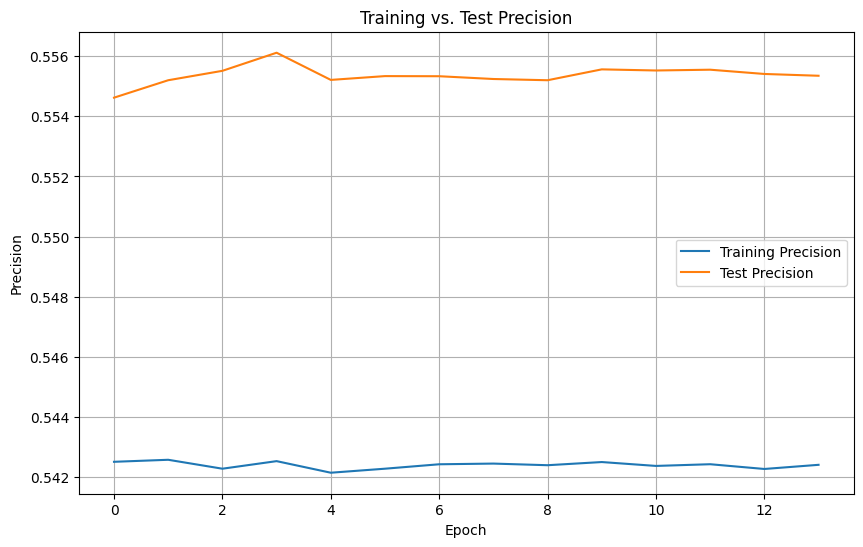

In [ ]:
# Learning visualisation for the Deep Neural Network (DNN)
# The model is not actually training, as the precision and accuracy score are not improving on TRAIN/TEST with more Epochs

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(best_history_nn['precision_10'], label='Training Precision')
plt.plot(best_history_nn['val_precision_10'], label='Test Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training vs. Test Precision')
plt.legend()
plt.grid(True)
plt.show()

# 2) Different Decision rules to improve precision (varying threshold)

best model1 **(clf_best)**: Decision Tree (max_depth=14 - manually selected second-best model)
best model2 **(rf_best)**: Random Forest (n_estimators=50, max_depth=19)

## 2.1. Predicting probabilities (predict_proba), getting the distribution for probabilities, and new decision rules

In [ ]:
# y_pred_test = best_lr.predict_proba(X_test)

# predicting probability instead of a lable

y_pred_test = rf_best.predict_proba(X_test)
y_pred_test_class1 = [k[1] for k in y_pred_test] # k[1] is the second element in the list of Class predictions

In [ ]:
# example prediction of probabilities
y_pred_test

array([[0.69485738, 0.30514262],
       [0.70368623, 0.29631377],
       [0.63114074, 0.36885926],
       ...,
       [0.64153394, 0.35846606],
       [0.4101268 , 0.5898732 ],
       [0.50001923, 0.49998077]])

In [ ]:
y_pred_test_class1_df = pd.DataFrame(y_pred_test_class1, columns=['Class1_probability'])
y_pred_test_class1_df.head()

,Class1_probability
0,0.305143
1,0.296314
2,0.368859
3,0.409182
4,0.445271


In [ ]:
# Mean prediction is 0.54, median is 0.55, 75% quantile is 0.60
y_pred_test_class1_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Class1_probability,31408.0,0.548344,0.084396,0.236243,0.492577,0.550658,0.606256,0.846048


In [ ]:
# Unconditional probability of a positive growth is 55.5%
y_test.sum()/y_test.count()

np.float64(0.5510697911360163)

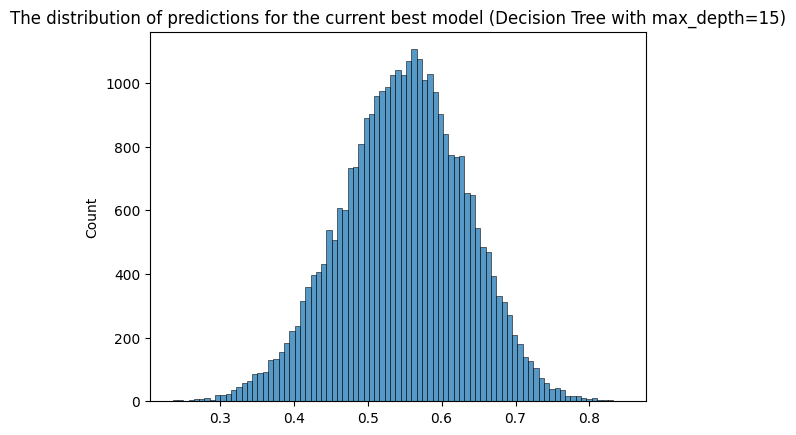

In [ ]:
# perfect shape for a Random Forest predictions vs. a Decision Tree - it's an average across many trees (estimators)
sns.histplot(y_pred_test_class1)

# Add a title
plt.title('The distribution of predictions for the current best model (Decision Tree with max_depth=15)')

# Show the plot
plt.show()

In [ ]:
# tpr (True Positive Rate) vs. fpr (False Positive Rate) dataframe
# tp = True Positive
# tn = True Negative
# fp = False Positive
# fn = False Negative
# Decision Rule :  "y_pred>= Threshold" for Class "1"

# when only_even=True --> we'll have a step ==0.02 and leave only even records

def tpr_fpr_dataframe(y_true, y_pred, only_even=False):
    scores = []

    if only_even==False:
      thresholds = np.linspace(0, 1, 101) #[0, 0.01, 0.02, ...0.99,1.0]
    else:
      thresholds = np.linspace(0, 1, 51) #[0, 0.02, 0.04,  ...0.98,1.0]

    for t in thresholds:

        actual_positive = (y_true == 1)
        actual_negative = (y_true == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        if tp + fp > 0:
          precision = tp / (tp + fp)

        if tp + fn > 0:
          recall = tp / (tp + fn)

        if precision+recall > 0:
          f1_score = 2*precision*recall / (precision+recall)

        accuracy = (tp+tn) / (tp+tn+fp+fn)

        scores.append((t, tp, fp, fn, tn, precision, recall, accuracy, f1_score))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn','precision','recall', 'accuracy','f1_score']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores


In [ ]:
df_scores = tpr_fpr_dataframe(y_test,
                              y_pred_test_class1,
                              only_even=True)

In [ ]:
# full df_scores
df_scores

,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
0,0.00,17308,14100,0,0,0.551070,1.000000,0.551070,0.710567,1.000000,1.000000
1,0.02,17308,14100,0,0,0.551070,1.000000,0.551070,0.710567,1.000000,1.000000
2,0.04,17308,14100,0,0,0.551070,1.000000,0.551070,0.710567,1.000000,1.000000
3,0.06,17308,14100,0,0,0.551070,1.000000,0.551070,0.710567,1.000000,1.000000
4,0.08,17308,14100,0,0,0.551070,1.000000,0.551070,0.710567,1.000000,1.000000
5,0.10,17308,14100,0,0,0.551070,1.000000,0.551070,0.710567,1.000000,1.000000
6,0.12,17308,14100,0,0,0.551070,1.000000,0.551070,0.710567,1.000000,1.000000
7,0.14,17308,14100,0,0,0.551070,1.000000,0.551070,0.710567,1.000000,1.000000
8,0.16,17308,14100,0,0,0.551070,1.000000,0.551070,0.710567,1.000000,1.000000
9,0.18,17308,14100,0,0,0.551070,1.000000,0.551070,0.710567,1.000000,1.000000


In [ ]:
df_scores[(df_scores.threshold>=0.5) & (df_scores.threshold<=0.8)]

,threshold,tp,fp,fn,tn,precision,recall,accuracy,f1_score,tpr,fpr
25,0.50,12668,9975,4640,4125,0.559467,0.731916,0.534673,0.634177,0.731916,0.707447
26,0.52,11224,8840,6084,5260,0.559410,0.648486,0.524834,0.600664,0.648486,0.626950
27,0.54,9670,7551,7638,6549,0.561524,0.558701,0.516397,0.560109,0.558701,0.535532
28,0.56,8039,6261,9269,7839,0.562168,0.464467,0.505540,0.508669,0.464467,0.444043
29,0.58,6423,4935,10885,9165,0.565504,0.371100,0.496307,0.448127,0.371100,0.350000
30,0.60,4891,3735,12417,10365,0.567007,0.282586,0.485736,0.377188,0.282586,0.264894
31,0.62,3627,2739,13681,11361,0.569746,0.209556,0.477203,0.306412,0.209556,0.194255
32,0.64,2455,1903,14853,12197,0.563332,0.141842,0.466505,0.226622,0.141842,0.134965
33,0.66,1632,1224,15676,12876,0.571429,0.094292,0.461921,0.161873,0.094292,0.086809
34,0.68,983,752,16325,13348,0.566571,0.056795,0.456285,0.103240,0.056795,0.053333


<Axes: title={'center': 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=15)'}, xlabel='threshold'>

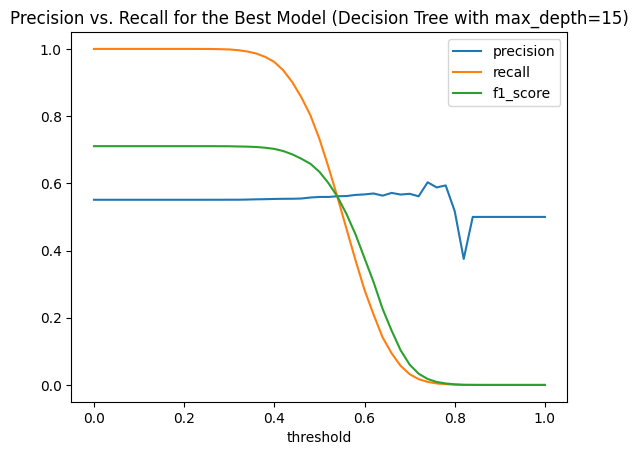

In [ ]:
# Try to find high Precision score points

df_scores.plot.line(x='threshold',
                    y=['precision','recall', 'f1_score'],
                    title = 'Precision vs. Recall for the Best Model (Decision Tree with max_depth=15)')

## 2.2) [Code Snippet 6] Defining new columns with Predictions in new_df: pred7..pred10
* pred7 and pred8 are 2 decision rules for the Decision Tree (best model with max_depth=15)
* pred9 and pred10 are 2 decision rules for the Random Forest (second best model)

In [ ]:
# adding Decision Tree predictors (clf_best) to the dataset for 2 new rules based on thresholds


y_pred_all = clf_best.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list

# defining a new prediction vector is easy now, as the dimensions will match
new_df['proba_pred8'] = y_pred_all_class1_array
new_df['pred8_clf_second_best_rule_84'] = (y_pred_all_class1_array >= 0.84).astype(int)

new_df['proba_pred9'] = y_pred_all_class1_array
new_df['pred9_clf_second_best_rule_92'] = (y_pred_all_class1_array >= 0.92).astype(int)

In [ ]:
# adding Random Forest predictors (rf_best)
rf_best

RandomForestClassifier(max_depth=19, n_estimators=50, n_jobs=-1,
                       random_state=42)

In [ ]:
# make predictions of probabilities using the Random Forest model (rf_best)

y_pred_all = rf_best.predict_proba(X_all)
y_pred_all_class1 = [k[1] for k in y_pred_all] #list of predictions for class "1"
y_pred_all_class1_array = np.array(y_pred_all_class1) # (Numpy Array) np.array of predictions for class "1" , converted from a list


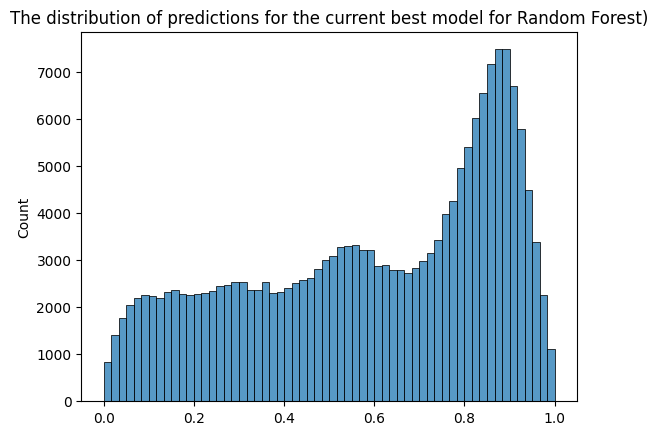

In [ ]:
# PREDICTIONS ON A FULL DATASET - different from on a TRAINED SET (too optimistic? or just a bullish environment?)
sns.histplot(y_pred_all_class1)

# Add a title
plt.title('The distribution of predictions for the current best model for Random Forest)')

# Show the plot
plt.show()

In [ ]:
# adding Random Forest predictors (rf_best) to the dataset for 2 new rules, based on Thresholds
# defining a new prediction vector is easy now, as the dimensions will match
new_df['proba_pred10'] = y_pred_all_class1_array
new_df['pred10_rf_best_rule_55'] = (y_pred_all_class1_array >= 0.55).astype(int)

new_df['proba_pred11'] = y_pred_all_class1_array
new_df['pred11_rf_best_rule_65'] = (y_pred_all_class1_array >= 0.65).astype(int)

<Axes: >

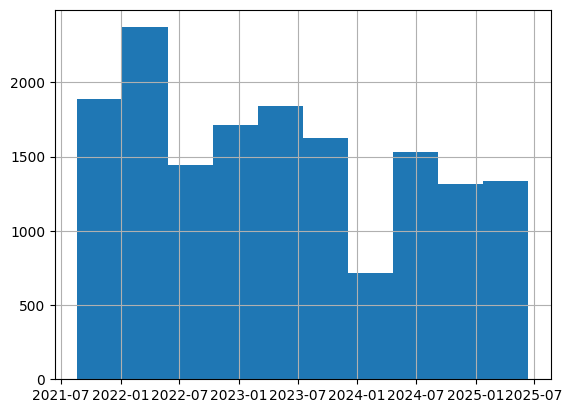

In [ ]:
# Many positive predictions
new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_55==1)].Date.hist()

<Axes: >

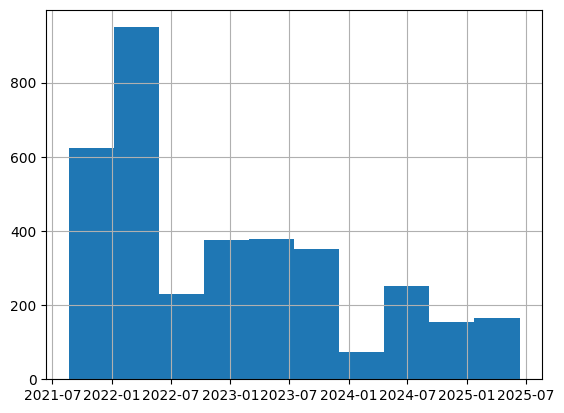

In [ ]:
# Vs. less positives on higher-threshold rule
new_df[(new_df.split=='test')&(new_df.pred11_rf_best_rule_65==1)].Date.hist()

In [ ]:
# sample of rare predictions with high threshold vs. other predictions
new_df[(new_df.split=='test')&(new_df.pred11_rf_best_rule_65==1)].sort_values(by='Date').sample(10)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,pred6_clf_best,is_correct_pred6,proba_pred8,pred8_clf_second_best_rule_84,proba_pred9,pred9_clf_second_best_rule_92,proba_pred10,pred10_rf_best_rule_55,proba_pred11,pred11_rf_best_rule_65
6484,113.758424,116.583005,111.543068,114.626106,5173306.0,0.0,0.0,SIE.DE,2022,February,...,0,1,0.181818,0,0.181818,0,0.650718,1,0.650718,1
5708,21.172768,21.377369,20.610861,20.658768,343069000.0,0.0,0.0,NVDA,2021,September,...,0,0,0.000000,0,0.000000,0,0.689672,1,0.689672,1
7114,151.548214,151.755618,149.010073,149.266846,901900.0,0.0,0.0,SAP,2023,December,...,1,1,0.926635,1,0.926635,1,0.659772,1,0.659772,1
6994,402.504104,405.639898,400.538381,401.006409,8620154.0,0.0,0.0,ITC.NS,2023,October,...,1,1,0.979630,1,0.979630,1,0.666413,1,0.666413,1
4740,3574.641391,3592.563176,3551.343117,3576.244873,1441148.0,0.0,0.0,TCS.NS,2021,September,...,1,0,1.000000,1,1.000000,1,0.671300,1,0.671300,1
5749,56.919998,57.090000,56.849998,57.000000,1552400.0,0.0,0.0,HDB,2024,May,...,0,0,0.500000,0,0.500000,0,0.661496,1,0.661496,1
2513,191.676618,198.952325,190.382713,197.688278,24549800.0,0.0,0.0,META,2022,May,...,0,1,0.181818,0,0.181818,0,0.734752,1,0.734752,1
6024,390.315686,392.492168,387.365356,387.365356,307945.0,0.0,0.0,OR.PA,2023,June,...,1,1,0.976441,1,0.976441,1,0.663538,1,0.663538,1
3824,24.860001,25.240000,24.840000,25.219999,497200.0,0.0,0.0,IDEXY,2025,April,...,1,1,1.000000,1,1.000000,1,0.667565,1,0.667565,1
6755,301.750000,306.589996,300.760010,302.880005,4993000.0,0.0,0.0,BRK-B,2023,March,...,0,0,0.000000,0,0.000000,0,0.736172,1,0.736172,1


In [ ]:
# List of ALL current predictions
PREDICTIONS = [k for k in new_df.keys() if k.startswith('pred')]
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds',
 'pred5_clf_10',
 'pred6_clf_5',
 'pred6_clf_best',
 'pred8_clf_second_best_rule_84',
 'pred9_clf_second_best_rule_92',
 'pred10_rf_best_rule_55',
 'pred11_rf_best_rule_65']

In [ ]:
# Pred 10: How many positive prediction per day (out of 33 stocks possible)
pred10_daily_positive_count = pd.DataFrame(new_df[(new_df.split=='test')&(new_df.pred11_rf_best_rule_65==1)].groupby('Date')['pred11_rf_best_rule_65'].count())

In [ ]:
# Pred 9: How many positive prediction per day (out of 33 stocks possible)
pred9_daily_positive_count = pd.DataFrame(new_df[(new_df.split=='test')&(new_df.pred10_rf_best_rule_55==1)].groupby('Date')['pred10_rf_best_rule_55'].count())

In [ ]:
# Unique trading days on Test (4 years)
new_df[(new_df.split=='test')].Date.nunique()

991

In [ ]:
pred10_daily_positive_count

,pred11_rf_best_rule_65
Date,
2021-08-20,7
2021-08-23,9
2021-08-24,8
2021-08-25,8
2021-08-26,6
...,...
2025-06-05,5
2025-06-06,2
2025-06-10,3


array([[<Axes: title={'center': 'pred11_rf_best_rule_65'}>]], dtype=object)

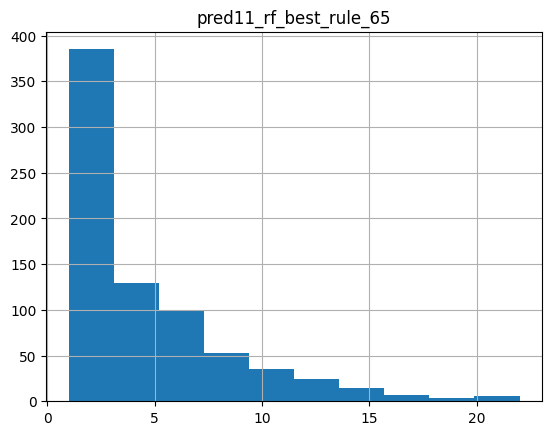

In [ ]:
pred10_daily_positive_count.hist()

In [ ]:
# 75% cases we have not more than 6 bets of $100
pred10_daily_positive_count.describe().T

,count,mean,std,min,25%,50%,75%,max
pred11_rf_best_rule_65,758.0,4.686016,3.977691,1.0,2.0,3.0,6.0,22.0


array([[<Axes: title={'center': 'pred10_rf_best_rule_55'}>]], dtype=object)

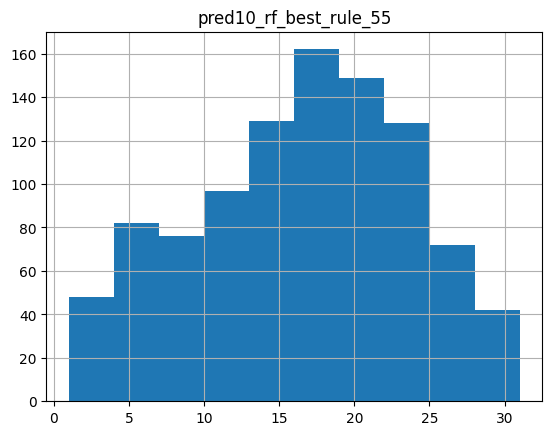

In [ ]:
pred9_daily_positive_count.hist()

In [ ]:
pred9_daily_positive_count.describe().T

,count,mean,std,min,25%,50%,75%,max
pred10_rf_best_rule_55,985.0,16.02335,7.125078,1.0,11.0,17.0,21.0,31.0


## 2.3) Agg. stats on ALL predictions

In [ ]:
# let's review the Predictions:
PREDICTIONS, IS_CORRECT = get_predictions_correctness(new_df, to_predict=to_predict)


Prediction columns founded: ['pred0_manual_cci', 'pred1_manual_prev_g1', 'pred2_manual_prev_g1_and_snp', 'pred3_manual_dgs10_5', 'pred4_manual_dgs10_fedfunds', 'pred5_clf_10', 'pred6_clf_5', 'pred6_clf_best', 'pred8_clf_second_best_rule_84', 'pred9_clf_second_best_rule_92', 'pred10_rf_best_rule_55', 'pred11_rf_best_rule_65']
Created columns is_correct: ['is_correct_pred0', 'is_correct_pred1', 'is_correct_pred2', 'is_correct_pred3', 'is_correct_pred4', 'is_correct_pred5', 'is_correct_pred6', 'is_correct_pred8', 'is_correct_pred9', 'is_correct_pred10', 'is_correct_pred11']
Precision on TEST set for each prediction:
Prediction column:pred0_manual_cci , is_correct_column: is_correct_pred0
is_correct_pred0
1    443
0    351
Name: count, dtype: int64
is_correct_pred0
1    0.557935
0    0.442065
Name: count, dtype: float64
---------
Prediction column:pred1_manual_prev_g1 , is_correct_column: is_correct_pred1
is_correct_pred1
1    9748
0    8243
Name: count, dtype: int64
is_correct_pred1
1    

In [ ]:
# check approx. periods : Train, Valid , Test
new_df.groupby('split').Date.agg(['min','max'])

,min,max
split,,
test,2021-08-20,2025-06-13
train,2000-01-03,2017-10-25
validation,2017-10-26,2021-08-19


In [ ]:
# Extract number from the prediction column

# Example string
example_string = "pred10_rf_best_rule_60"

# Split the string by '_'
parts = example_string.split('_')

# Extract the part with 'pred' and remove the 'pred' prefix
pred_number = parts[0].replace('pred', '')

# Print the result
print(pred_number)

# Print in one line
print(int(example_string.split('_')[0].replace('pred', '')))


10
10


In [ ]:
# all predictions
PREDICTIONS

['pred0_manual_cci',
 'pred1_manual_prev_g1',
 'pred2_manual_prev_g1_and_snp',
 'pred3_manual_dgs10_5',
 'pred4_manual_dgs10_fedfunds',
 'pred5_clf_10',
 'pred6_clf_5',
 'pred6_clf_best',
 'pred8_clf_second_best_rule_84',
 'pred9_clf_second_best_rule_92',
 'pred10_rf_best_rule_55',
 'pred11_rf_best_rule_65']

In [ ]:
# all predictions on MODELS (not-manual predictions)
PREDICTIONS_ON_MODELS = [p for p in PREDICTIONS if int(p.split('_')[0].replace('pred', ''))>=5]
PREDICTIONS_ON_MODELS

['pred5_clf_10',
 'pred6_clf_5',
 'pred6_clf_best',
 'pred8_clf_second_best_rule_84',
 'pred9_clf_second_best_rule_92',
 'pred10_rf_best_rule_55',
 'pred11_rf_best_rule_65']

In [ ]:
# all predictions on Models - correctness
IS_CORRECT_ON_MODELS = [p for p in IS_CORRECT if int(p.replace('is_correct_pred', ''))>=5]
IS_CORRECT_ON_MODELS

['is_correct_pred5',
 'is_correct_pred6',
 'is_correct_pred8',
 'is_correct_pred9',
 'is_correct_pred10',
 'is_correct_pred11']

In [ ]:
# predictions on models
# pred10_rf_best_rule_60: ONLY 2% of TEST cases predicted with high confidence of growth
new_df.groupby('split')[PREDICTIONS_ON_MODELS].agg(['count','sum','mean']).T

split                                        test          train    validation
pred5_clf_10                  count  31408.000000  129730.000000  30657.000000
                              sum    19026.000000   99169.000000  23690.000000
                              mean       0.605769       0.764426      0.772744
pred6_clf_5                   count  31408.000000  129730.000000  30657.000000
                              sum    18452.000000  104161.000000  22899.000000
                              mean       0.587494       0.802906      0.746942
pred6_clf_best                count  31408.000000  129730.000000  30657.000000
                              sum    18287.000000   90027.000000  22691.000000
                              mean       0.582240       0.693957      0.740157
pred8_clf_second_best_rule_84 count  31408.000000  129730.000000  30657.000000
                              sum    15716.000000   33382.000000  11392.000000
                              mean       0.500382       0.257319      0.371595
pred9_clf_second_best_rule_92 count  31408.000000  129730.000000  30657.000000
                              sum    13832.000000   20128.000000   6470.000000
                              mean       0.440397       0.155153      0.211045
pred10_rf_best_rule_55        count  31408.000000  129730.000000  30657.000000
                              sum    15783.000000   77622.000000  19847.000000
                              mean       0.502515       0.598335      0.647389
pred11_rf_best_rule_65        count  31408.000000  129730.000000  30657.000000
                              sum     3552.000000   72153.000000  19218.000000
                              mean       0.113092       0.556178      0.626872

In [ ]:
# 11 predictions stats (check TEST set)
new_df.groupby('split')[PREDICTIONS].agg(['count','sum','mean']).T

split                                        test          train    validation
pred0_manual_cci              count  31408.000000  129730.000000  30657.000000
                              sum      794.000000    3428.000000    886.000000
                              mean       0.025280       0.026424      0.028900
pred1_manual_prev_g1          count  31408.000000  129730.000000  30657.000000
                              sum    17991.000000   76372.000000  19721.000000
                              mean       0.572816       0.588700      0.643279
pred2_manual_prev_g1_and_snp  count  31408.000000  129730.000000  30657.000000
                              sum    13367.000000   57404.000000  16695.000000
                              mean       0.425592       0.442488      0.544574
pred3_manual_dgs10_5          count  31408.000000  129730.000000  30657.000000
                              sum      997.000000   13333.000000  11908.000000
                              mean       0.031744       0.102775      0.388427
pred4_manual_dgs10_fedfunds   count  31408.000000  129730.000000  30657.000000
                              sum     5660.000000   30611.000000      0.000000
                              mean       0.180209       0.235959      0.000000
pred5_clf_10                  count  31408.000000  129730.000000  30657.000000
                              sum    19026.000000   99169.000000  23690.000000
                              mean       0.605769       0.764426      0.772744
pred6_clf_5                   count  31408.000000  129730.000000  30657.000000
                              sum    18452.000000  104161.000000  22899.000000
                              mean       0.587494       0.802906      0.746942
pred6_clf_best                count  31408.000000  129730.000000  30657.000000
                              sum    18287.000000   90027.000000  22691.000000
                              mean       0.582240       0.693957      0.740157
pred8_clf_second_best_rule_84 count  31408.000000  129730.000000  30657.000000
                              sum    15716.000000   33382.000000  11392.000000
                              mean       0.500382       0.257319      0.371595
pred9_clf_second_best_rule_92 count  31408.000000  129730.000000  30657.000000
                              sum    13832.000000   20128.000000   6470.000000
                              mean       0.440397       0.155153      0.211045
pred10_rf_best_rule_55        count  31408.000000  129730.000000  30657.000000
                              sum    15783.000000   77622.000000  19847.000000
                              mean       0.502515       0.598335      0.647389
pred11_rf_best_rule_65        count  31408.000000  129730.000000  30657.000000
                              sum     3552.000000   72153.000000  19218.000000
                              mean       0.113092       0.556178      0.626872

# 3) Trading Simulations

* create simulation 1 features: like "sim1_pred0" ... "sim1_predLast"

## 3.1) Investing $100 on every positive prediction
* fees = 0.1% for each buy and sell operation ==> 0.2% for buy+sell operation

In [ ]:
# current prediction
pred = 'pred6_clf_best'

In [ ]:
# Total Number of Investment Opportunities
new_df[new_df.split=='test'].Close_x.count()

np.int64(31408)

In [ ]:
# Total Number of Days (~4 years of trading)
new_df[new_df.split=='test'].Date.nunique()

991

In [ ]:
# check actual future growth with 'growth_future_5d', correctness of the prediction with 'is_positive_growth_5d_future'
TO_PREDICT

['growth_future_30d', 'is_positive_growth_30d_future']

In [ ]:
# Sample
new_df[['growth_future_30d','is_positive_growth_30d_future',pred]].sample(5)

,growth_future_30d,is_positive_growth_30d_future,pred6_clf_best
3442,1.056813,1,0
4023,1.017979,1,1
3567,0.967257,0,0
11196,0.997812,0,1
2514,1.061447,1,1


In [ ]:
# GROSS REVENUE: ONLY when current_prediction equals to 1: invest $100 into that stock (buy), and sell in 1week (sell)
new_df['sim1_gross_rev_pred6'] = new_df[pred] * 100 * (new_df['growth_future_30d']-1)

In [ ]:
# FEES: 0.1% for each operation , 0.2% for buy+sell ONLY when current_prediction equals to one
new_df['sim1_fees_pred6'] = -new_df[pred] * 100 * 0.002

In [ ]:
# NET REVENUE: GROSS_REVENUE + FEES
new_df['sim1_net_rev_pred6'] = new_df['sim1_gross_rev_pred6'] + new_df['sim1_fees_pred6']

In [ ]:
# sample of individual results
COLUMNS_FIN_RESULT = ['Date','Ticker','Close_x']+TO_PREDICT+ [pred,  'sim1_gross_rev_pred6','sim1_fees_pred6','sim1_net_rev_pred6']
new_df[(new_df.split=='test')&(new_df[pred]==1)][COLUMNS_FIN_RESULT].sample(5)

,Date,Ticker,Close_x,growth_future_30d,is_positive_growth_30d_future,pred6_clf_best,sim1_gross_rev_pred6,sim1_fees_pred6,sim1_net_rev_pred6
3032,2024-06-07,META,491.168152,0.992322,0,1,-0.767767,-0.2,-0.967767
3075,2022-04-06,IDEXY,9.564548,1.033950,1,1,3.395031,-0.2,3.195031
6119,2023-10-18,RMS.PA,1665.814087,1.125148,1,1,12.514827,-0.2,12.314827
6708,2023-01-03,BRK-B,309.910004,0.999097,0,1,-0.090348,-0.2,-0.290348
6298,2024-07-03,RMS.PA,2105.767090,0.981105,0,1,-1.889470,-0.2,-2.089470


In [ ]:
# DAILY INVESTMENTS COUNT
filter_test_and_positive_pred = (new_df.split=='test')&(new_df[pred]==1)
df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
sim1_avg_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
print(sim1_avg_investments_per_day)

26.0


In [ ]:
# Distribution: how many times do we trade daily (for the current Prediction)?
df_investments_count_daily.describe().T

,count,mean,std,min,25%,50%,75%,max
pred6_clf_best,991.0,18.453078,7.890639,1.0,12.0,18.0,26.0,32.0


In [ ]:
new_df[(new_df.split=='test')&(new_df[pred]==1)][['sim1_gross_rev_pred6','sim1_fees_pred6','sim1_net_rev_pred6']].sum()

,0
sim1_gross_rev_pred6,50556.760238
sim1_fees_pred6,-3657.400000
sim1_net_rev_pred6,46968.360238


### 3.1.2 Calculate fin. results for all fields
* Simplified and approximate calculation

In [ ]:
# Calculate fin. result for ALL predictions (manual and produced by models)

sim1_results = [] # results in Array

# Iterate over all predictions
for pred in PREDICTIONS:
  print(f'Calculating sumulation for prediction {pred}:')
  print(f"    Count times of investment {len(new_df[(new_df.split=='test')&(new_df[pred]==1)])} out of {len(new_df[(new_df.split=='test')])} TEST records")

  # Prefix: e.g. pred1 or pred10
  pred_prefix= pred.split('_')[0]

  # Fin. result columns: define new records for EACH positive prediction
  new_df['sim1_gross_rev_'+pred_prefix] = new_df[pred] * 100 * (new_df['growth_future_30d']-1)
  new_df['sim1_fees_'+pred_prefix] = -new_df[pred] * 100 * 0.002
  new_df['sim1_net_rev_'+pred_prefix] = new_df['sim1_gross_rev_'+pred_prefix] + new_df['sim1_fees_'+pred_prefix]

  # calculate agg. results for each PREDICTION columns (pred) on TEST
  filter_test_and_positive_pred = (new_df.split=='test')&(new_df[pred]==1) # filter records on TEST set, when current prediction is 1 (we invest $100 for 1 week ahead - 5 periods)
  sim1_count_investments = len(new_df[filter_test_and_positive_pred])
  sim1_gross_rev = new_df[filter_test_and_positive_pred]['sim1_gross_rev_'+pred_prefix].sum()
  sim1_fees = new_df[filter_test_and_positive_pred]['sim1_fees_'+pred_prefix].sum()
  sim1_net_rev = new_df[filter_test_and_positive_pred]['sim1_net_rev_'+pred_prefix].sum()

  if sim1_gross_rev>0:
    sim1_fees_percentage = -sim1_fees/sim1_gross_rev
  else:
    sim1_fees_percentage = None

  if sim1_count_investments>0:
    sim1_average_net_revenue = sim1_net_rev/sim1_count_investments
  else:
    sim1_average_net_revenue = None

  # APPROXIMATE CAPITAL REQUIRED and CAGR Calculation
  df_investments_count_daily = pd.DataFrame(new_df[filter_test_and_positive_pred].groupby('Date')[pred].count())
  sim1_avg_investments_per_day = df_investments_count_daily[pred].mean()
  sim1_q75_investments_per_day = df_investments_count_daily[pred].quantile(0.75)  # 75% case - how many $100 investments per day do we have?
  # df_investments_count_daily[pred].mean()
  sim1_capital = 100 * 30 * sim1_q75_investments_per_day # 30 days in a row with positive predictions

  # CAGR: average growth per year. E.g. if you have 1.5 return (50% growth in 4 years) --> (1.5)**(1/4) = 1.106 or 10.6% average
  sim1_CAGR = ((sim1_capital+sim1_net_rev)/sim1_capital)**(1/4)

  # append to DF
  sim1_results.append((pred,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR))


  # output for all predictions with some positive predictions
  if  sim1_count_investments>1:
    print(f"    Financial Result: \n {new_df[filter_test_and_positive_pred][['sim1_gross_rev_'+pred_prefix,'sim1_fees_'+pred_prefix,'sim1_net_rev_'+pred_prefix]].sum()}")
    print(f"        Count Investments in 4 years (on TEST): {sim1_count_investments}")
    print(f"        Gross Revenue: ${int(sim1_gross_rev)}")
    print(f"        Fees (0.2% for buy+sell): ${int(-sim1_fees)}")
    print(f"        Net Revenue: ${int(sim1_net_rev)}")
    print(f"        Fees are {int(-100.0*sim1_fees/sim1_gross_rev)} % from Gross Revenue")
    print(f"        Capital Required : ${int(sim1_capital)} (Vbegin)")
    print(f"        Final value (Vbegin + Net_revenue) : ${int(sim1_capital + sim1_net_rev)} (Vfinal)")

    print(f"        Average CAGR on TEST (4 years) : {np.round(sim1_CAGR,3)}, or {np.round(100.0*(sim1_CAGR-1),1)}% ")

    print(f"        Average daily stats: ")
    print(f"            Average net revenue per investment: ${np.round(sim1_net_rev/sim1_count_investments,2)} ")
    print(f"            Average investments per day: {int(np.round(sim1_avg_investments_per_day))} ")
    print(f"            Q75 investments per day: {int(np.round(sim1_q75_investments_per_day))} ")
    print('=============================================+')


# results in a DataFrame from an Array
columns_simulation = ['prediction', 'sim1_count_investments', 'sim1_gross_rev', 'sim1_fees', 'sim1_net_rev', 'sim1_fees_percentage','sim1_average_net_revenue','sim1_avg_investments_per_day','sim1_capital','sim1_CAGR']

df_sim1_results = pd.DataFrame(sim1_results,columns=columns_simulation)

Calculating sumulation for prediction pred0_manual_cci:
    Count times of investment 794 out of 31408 TEST records
    Financial Result: 
 sim1_gross_rev_pred0    1613.043262
sim1_fees_pred0         -158.800000
sim1_net_rev_pred0      1459.643262
dtype: float64
        Count Investments in 4 years (on TEST): 794
        Gross Revenue: $1613
        Fees (0.2% for buy+sell): $158
        Net Revenue: $1459
        Fees are 9 % from Gross Revenue
        Capital Required : $6000 (Vbegin)
        Final value (Vbegin + Net_revenue) : $7459 (Vfinal)
        Average CAGR on TEST (4 years) : 1.056, or 5.6% 
        Average daily stats: 
            Average net revenue per investment: $1.84 
            Average investments per day: 2 
            Q75 investments per day: 2 
=============================================+
Calculating sumulation for prediction pred1_manual_prev_g1:
    Count times of investment 17991 out of 31408 TEST records
    Financial Result: 
 sim1_gross_rev_pred1    29618

In [ ]:
df_sim1_results['sim1_growth_capital_4y'] = (df_sim1_results.sim1_net_rev+df_sim1_results.sim1_capital) / df_sim1_results.sim1_capital

In [ ]:
# final comparison
df_sim1_results

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_4y
0,pred0_manual_cci,794,1613.043262,-158.8,1459.643262,0.098447,1.838342,1.850816,6000.0,1.055946,1.243274
1,pred1_manual_prev_g1,17991,29618.243475,-3598.2,26167.843475,0.121486,1.454496,18.154390,75000.0,1.077694,1.348905
2,pred2_manual_prev_g1_and_snp,13367,17019.666162,-2673.4,14475.066162,0.157077,1.082896,22.967354,81000.0,1.041960,1.178705
3,pred3_manual_dgs10_5,997,2845.843984,-199.4,2646.443984,0.070067,2.654407,31.156250,96000.0,1.006822,1.027567
4,pred4_manual_dgs10_fedfunds,5660,8594.814190,-1132.0,7660.814190,0.131707,1.353501,31.620112,99000.0,1.018808,1.077382
5,pred5_clf_10,19026,52201.779179,-3805.2,48474.579179,0.072894,2.547807,19.355036,93000.0,1.110577,1.521232
6,pred6_clf_5,18452,66649.328987,-3690.4,62985.328987,0.055370,3.413469,31.541880,99000.0,1.130994,1.636215
7,pred6_clf_best,18287,50556.760238,-3657.4,46968.360238,0.072342,2.568402,18.453078,78000.0,1.125062,1.602158
8,pred8_clf_second_best_rule_84,15716,49432.642407,-3143.2,46348.442407,0.063586,2.949125,15.906883,69000.0,1.137079,1.671717
9,pred9_clf_second_best_rule_92,13832,46778.614894,-2766.4,44069.814894,0.059138,3.186077,14.114286,57000.0,1.153949,1.773155


In [ ]:
# Create the scatter plot
fig = px.scatter(
    df_sim1_results.dropna(),
    x='sim1_avg_investments_per_day',
    y='sim1_CAGR',
    size='sim1_growth_capital_4y',  # Use the 'size' parameter for sim1_CAGR
    text='prediction',
    title='Compound Annual Growth vs. Time spent (Average investments per day)',
    labels={'sim1_capital': 'Initial Capital Requirement', 'growth_capital_4y': '4-Year Capital Growth'}
)

# Update the layout to improve readability of the annotations
fig.update_traces(textposition='top center')

# Show the plot
fig.show()

In [ ]:
# detailed info from the bubble chart above on the winners
# top 1 result
df_sim1_results[df_sim1_results.prediction.isin(['pred9_clf_second_best_rule_92'])]

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_4y
9,pred9_clf_second_best_rule_92,13832,46778.614894,-2766.4,44069.814894,0.059138,3.186077,14.114286,57000.0,1.153949,1.773155


In [ ]:
# top 2-3 results
df_sim1_results[df_sim1_results.prediction.isin(['pred8_clf_second_best_rule_84','pred7_clf_second_best'])]

,prediction,sim1_count_investments,sim1_gross_rev,sim1_fees,sim1_net_rev,sim1_fees_percentage,sim1_average_net_revenue,sim1_avg_investments_per_day,sim1_capital,sim1_CAGR,sim1_growth_capital_4y
8,pred8_clf_second_best_rule_84,15716,49432.642407,-3143.2,46348.442407,0.063586,2.949125,15.906883,69000.0,1.137079,1.671717


## 3.2. Advanced Simulation
* to_predict = 'is_positive_growth_30d_future'
* invest ~3% of capital each day (sell positions from 30 days ago), REINVEST PREVIOUS GAINS
* use predict_proba predictions
* select top1..3..x predictions > threshold (0.53)
* invest proportionally the prediction
* stop loss y%
* take profit z%
* Not included: portfolio optimization

### 3.2.1) [Code Snippet 1] Define rank of prediction (pred_14_rf_best_rule_53)
*  Current best prediction pred9_clf_second_best_rule_92, with CAGR = 1.155577 (15.56% average capital growth with simple simulation)

In [ ]:
# https://stackoverflow.com/questions/17775935/sql-like-window-functions-in-pandas-row-numbering-in-python-pandas-dataframe
# rank of prediction

new_df["pred9_rank"] = new_df.groupby("Date")["proba_pred9"].rank(method="first", ascending=False)

new_df["pred10_rank"] = new_df.groupby("Date")["proba_pred10"].rank(method="first", ascending=False)


In [ ]:
# CHECK RANK FOR 1 DAY:
  # we have predictions for all 33 stocks
first_trading_day_2024 = new_df[new_df.Date>='2024-01-04'].Date.unique().astype(str)[0]
first_trading_day_2024
print(f'First trading day in 2024: {first_trading_day_2024}, count predictions = {len(new_df[new_df.Date==first_trading_day_2024])}')

First trading day in 2024: 2024-01-04, count predictions = 33


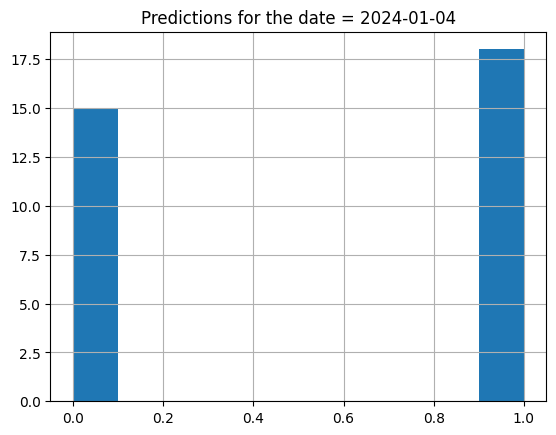

In [ ]:
# Decision Tree's predictions are not very smooth - either too small or too big
new_df[new_df.Date==first_trading_day_2024].proba_pred9.hist()
plt.title(f'Predictions for the date = {first_trading_day_2024}')
# Show the plot
plt.show()

In [ ]:
new_df[new_df.Date==first_trading_day_2024][['Date','Ticker', 'Close_x','proba_pred9','pred9_rank']].sort_values(by='pred9_rank').head(5)

,Date,Ticker,Close_x,proba_pred9,pred9_rank
6703,2024-01-04,AMZN,144.570007,1.0,1.0
2925,2024-01-04,META,345.491669,1.0,2.0
3627,2024-01-04,AVGO,103.194565,1.0,3.0
8107,2024-01-04,TTE,63.683601,1.0,4.0
5343,2024-01-04,BHARTIARTL.NS,1042.092651,1.0,5.0


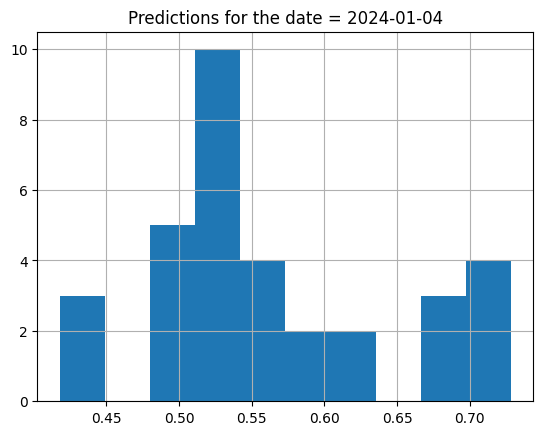

In [ ]:
# Random Forest's predictions are more spreaded across the range - rank() function will work
new_df[new_df.Date==first_trading_day_2024].proba_pred10.hist()
plt.title(f'Predictions for the date = {first_trading_day_2024}')
# Show the plot
plt.show()

In [ ]:
# It is quite different vs. a single Decision tree (proba_pred9 vs. proba_pred10)
new_df[new_df.Date==first_trading_day_2024][['Date','Ticker', 'Close_x','proba_pred9','proba_pred10','pred10_rank']].sort_values(by='pred10_rank').head(5)

,Date,Ticker,Close_x,proba_pred9,proba_pred10,pred10_rank
10855,2024-01-04,AAPL,180.587540,0.980769,0.728263,1.0
6172,2024-01-04,RMS.PA,1828.443481,0.000000,0.710473,2.0
4877,2024-01-04,GOOG,137.224304,0.000000,0.710437,3.0
6278,2024-01-04,NVDA,47.976650,0.000000,0.701724,4.0
6703,2024-01-04,AMZN,144.570007,1.000000,0.695603,5.0


In [ ]:
# OUTCOME: let's use pred10_proba for Advanced simulations

### 3.2.2 Define Min(Low) for the next 5 days and Max(High) for the next 5 days
* Assymetric! distributions for Max_High_Next_5 / Adj_close_today vs. Min_Low_Next_5/Adj_close_today

In [ ]:
# Sort the DataFrame by Ticker and Date
new_df = new_df.sort_values(by=['Ticker', 'Date'])

In [ ]:
new_df['growth_future_30d'].describe().T

,growth_future_30d
count,190805.000000
mean,1.024153
std,0.116592
min,0.246131
25%,0.961696
50%,1.021542
75%,1.083104
max,5.179689


In [ ]:
# take profit if growth >=20%
new_df['growth_future_30d'].quantile(0.95)

np.float64(1.2009115514582216)

In [ ]:
# stop loss when -11%
new_df['growth_future_30d'].quantile(0.1)

np.float64(0.8989352558474176)

In [ ]:
# check a sample on the test dataset
new_df[new_df.split=='test'][['Date','High','Low','Close_x','Ticker','ticker_type','growth_future_30d']].sample(10)

,Date,High,Low,Close_x,Ticker,ticker_type,growth_future_30d
9348,2023-04-17,286.508853,281.163829,283.757721,MSFT,US,1.149356
6417,2022-11-11,101.190002,96.660004,100.790001,AMZN,US,0.823891
5383,2022-12-12,68.758603,67.729400,68.590363,HDB,INDIA,0.981244
4810,2021-11-10,727.321501,697.114968,724.808411,BHARTIARTL.NS,INDIA,0.922904
6881,2024-09-19,190.990005,188.470001,189.869995,AMZN,US,0.981724
6215,2024-03-05,2272.149367,2235.533720,2242.955811,RMS.PA,EU,1.025811
6869,2023-04-28,548.971353,534.832102,546.937927,SBIN.NS,INDIA,1.020050
6319,2024-04-22,16.851597,16.434910,16.764383,INFY,INDIA,0.990773
648,2024-12-31,903.000000,883.099976,892.000000,LICI.NS,INDIA,0.906839
6498,2024-11-18,141.517393,137.118397,140.117706,NVDA,US,0.986939


In [ ]:
# Define a function to get the rolling max High and min Low for the next 30 trading days

# Sort the DataFrame: Sorting by Ticker and Date ensures that we are looking at each ticker's data in chronological order.
# Rolling window calculation: We use the rolling method with a window of 5 to calculate the maximum high and minimum low over the next 5 days.
# The shift method is used to align these values correctly with the current row.

def rolling_max_min(df, window=30):
    # high/low in 30 days
    df['Max_High_Next_30'] = df['High'].rolling(window=window, min_periods=1).max().shift(-window+1)
    df['Min_Low_Next_30'] = df['Low'].rolling(window=window, min_periods=1).min().shift(-window+1)

    # low in 1 day (for lower entry)
    df['Min_Low_Next_1'] = df['Low'].rolling(window=1, min_periods=1).min().shift(-1)
    return df

In [ ]:
# Apply the function to each group of Ticker
# Important!: need to drop index from groupby operation (reset_index) - so that you can merge that afterwards
result = new_df[new_df.split=='test'][['Date','High','Low','Close_x','Ticker']].groupby('Ticker').apply(rolling_max_min).reset_index(drop=True)
result.head(30)

/tmp/ipython-input-1191106210.py:3: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



,Date,High,Low,Close_x,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1
0,2021-08-20,145.542655,143.856907,145.238831,AAPL,154.128160,136.339633,144.944814
1,2021-08-23,147.199013,144.944814,146.728577,AAPL,154.128160,135.516410,146.179724
2,2021-08-24,147.855677,146.179724,146.640366,AAPL,154.128160,135.516410,144.856596
3,2021-08-25,147.326415,144.856596,145.405441,AAPL,154.128160,135.516410,144.572375
4,2021-08-26,146.150313,144.572375,144.601776,AAPL,154.128160,135.516410,143.905901
5,2021-08-27,145.787662,143.905901,145.640656,AAPL,154.128160,135.516410,145.650469
6,2021-08-30,150.433290,145.650469,150.070648,AAPL,154.128160,135.516410,148.277081
7,2021-08-31,149.757019,148.277081,148.806335,AAPL,154.128160,135.516410,149.306166
8,2021-09-01,151.893590,149.306166,149.472778,AAPL,154.128160,135.516410,149.364951
9,2021-09-02,151.638756,149.364951,150.590057,AAPL,154.128160,135.516410,150.041248


In [ ]:
result[result.Ticker=='AAPL'].tail(10)

,Date,High,Low,Close_x,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1
948,2025-06-02,202.130005,200.119995,201.699997,AAPL,NaN,NaN,200.960007
949,2025-06-03,203.770004,200.960007,203.270004,AAPL,NaN,NaN,202.100006
950,2025-06-04,206.240005,202.100006,202.820007,AAPL,NaN,NaN,200.149994
951,2025-06-05,204.750000,200.149994,200.630005,AAPL,NaN,NaN,202.050003
952,2025-06-06,205.699997,202.050003,203.919998,AAPL,NaN,NaN,200.020004
953,2025-06-09,206.000000,200.020004,201.449997,AAPL,NaN,NaN,200.570007
954,2025-06-10,204.350006,200.570007,202.669998,AAPL,NaN,NaN,198.410004
955,2025-06-11,204.500000,198.410004,198.779999,AAPL,NaN,NaN,197.360001
956,2025-06-12,199.679993,197.360001,199.199997,AAPL,NaN,NaN,195.699997
957,2025-06-13,200.369995,195.699997,196.449997,AAPL,NaN,NaN,NaN


In [ ]:
# Calculate the ratios + safe divide
result['Ratio_MaxHighNext30_to_Close'] = np.where(result['Close_x'] == 0, np.nan, result['Max_High_Next_30']/result['Close_x'])
result['Ratio_MinLowNext30_to_Close'] =  np.where(result['Close_x'] == 0, np.nan,  result['Min_Low_Next_30']/result['Close_x'])

result['Ratio_MinLowNext1_to_Close'] =  np.where(result['Close_x'] == 0, np.nan,  result['Min_Low_Next_1']/result['Close_x'])

In [ ]:
result[result.Ticker=='AAPL'].head(10)

,Date,High,Low,Close_x,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close
0,2021-08-20,145.542655,143.856907,145.238831,AAPL,154.12816,136.339633,144.944814,1.061205,0.938727,0.997976
1,2021-08-23,147.199013,144.944814,146.728577,AAPL,154.12816,135.516410,146.179724,1.050430,0.923586,0.996259
2,2021-08-24,147.855677,146.179724,146.640366,AAPL,154.12816,135.516410,144.856596,1.051062,0.924141,0.987836
3,2021-08-25,147.326415,144.856596,145.405441,AAPL,154.12816,135.516410,144.572375,1.059989,0.931990,0.994271
4,2021-08-26,146.150313,144.572375,144.601776,AAPL,154.12816,135.516410,143.905901,1.065880,0.937170,0.995188
5,2021-08-27,145.787662,143.905901,145.640656,AAPL,154.12816,135.516410,145.650469,1.058277,0.930485,1.000067
6,2021-08-30,150.433290,145.650469,150.070648,AAPL,154.12816,135.516410,148.277081,1.027037,0.903017,0.988049
7,2021-08-31,149.757019,148.277081,148.806335,AAPL,154.12816,135.516410,149.306166,1.035763,0.910690,1.003359
8,2021-09-01,151.893590,149.306166,149.472778,AAPL,154.12816,135.516410,149.364951,1.031145,0.906629,0.999279
9,2021-09-02,151.638756,149.364951,150.590057,AAPL,154.12816,135.516410,150.041248,1.023495,0.899903,0.996356


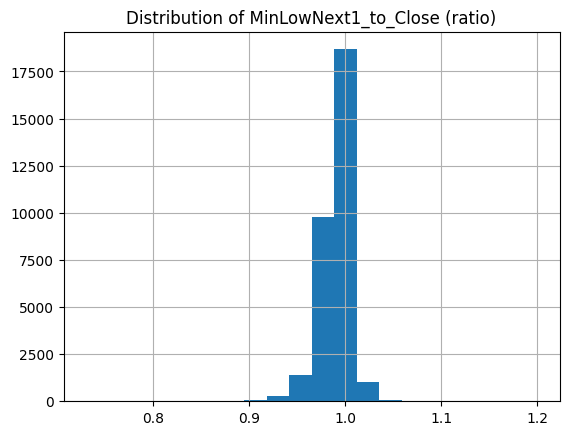

In [ ]:
result.Ratio_MinLowNext1_to_Close.hist(bins=20)
plt.title(f'Distribution of MinLowNext1_to_Close (ratio)')
# Show the plot
plt.show()

In [ ]:
result.Ratio_MinLowNext1_to_Close.describe().T

,Ratio_MinLowNext1_to_Close
count,31375.000000
mean,0.989868
std,0.015992
min,0.729876
25%,0.983424
50%,0.992051
75%,0.998520
max,1.199653


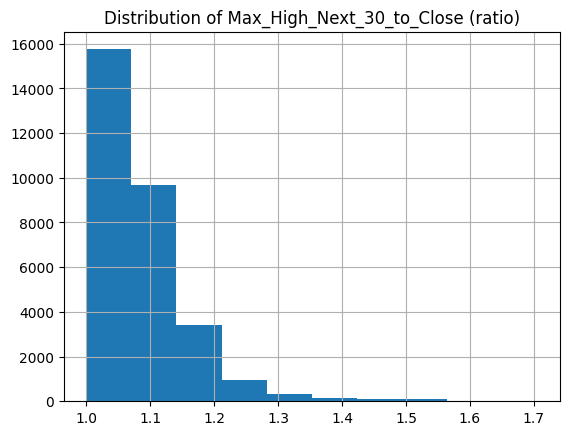

In [ ]:
result.Ratio_MaxHighNext30_to_Close.hist()
plt.title(f'Distribution of Max_High_Next_30_to_Close (ratio)')
# Show the plot
plt.show()

In [ ]:
result.Ratio_MaxHighNext30_to_Close.describe().T

,Ratio_MaxHighNext30_to_Close
count,30451.000000
mean,1.084827
std,0.074341
min,1.000000
25%,1.032117
50%,1.067683
75%,1.115220
max,1.705241


In [ ]:
result[result.Ratio_MaxHighNext30_to_Close>=1.3].sample(5)

,Date,High,Low,Close_x,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close
4254,2023-04-26,60.366640,59.434690,59.694317,AVGO,89.298814,58.250854,58.438803,1.495935,0.975819,0.978968
15711,2024-01-08,841.069278,811.742289,816.250305,LICI.NS,1164.161173,811.742289,820.857421,1.426231,0.994477,1.005644
3214,2022-12-27,535.259538,525.475023,526.131226,ASML,684.221530,518.129350,518.129350,1.300477,0.984791,0.984791
4658,2024-12-03,167.314077,163.098158,167.194748,AVGO,250.449082,163.098158,167.602426,1.497948,0.975498,1.002438
21482,2024-02-13,73.417335,69.589044,72.095924,NVDA,97.361245,66.218539,71.906009,1.350440,0.918478,0.997366


In [ ]:
# ~1.8% cases TAKE PROFIT (30%)
len(result[result.Ratio_MaxHighNext30_to_Close>=1.3])/len(result)

0.017861691288843608

<Axes: >

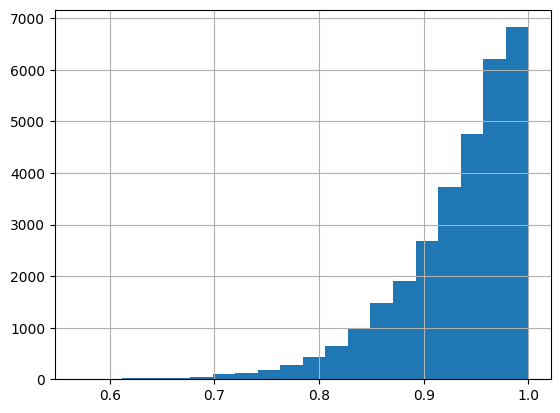

In [ ]:
# High intra-day volatility, especially on earlier days after the IPO
result.Ratio_MinLowNext30_to_Close.hist(bins=20)

In [ ]:
result.Ratio_MinLowNext30_to_Close.describe().T

,Ratio_MinLowNext30_to_Close
count,30451.000000
mean,0.931467
std,0.058795
min,0.568969
25%,0.903605
50%,0.947314
75%,0.976029
max,1.000000


In [ ]:
result[result.Ratio_MinLowNext30_to_Close<=0.8].sample(5)

,Date,High,Low,Close_x,Ticker,Max_High_Next_30,Min_Low_Next_30,Min_Low_Next_1,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close
6820,2022-02-17,625.570689,606.021605,607.883423,CDI.PA,625.570689,477.556110,600.436093,1.029096,0.785605,0.987749
11603,2022-02-07,12.842036,12.636634,12.663426,IDEXY,13.502892,9.368078,12.824173,1.066291,0.739774,1.012694
21011,2022-03-29,28.898199,27.933795,28.608679,NVDA,28.898199,16.799209,27.457577,1.010120,0.587207,0.959764
7915,2022-08-12,121.925262,119.688558,121.925262,GOOG,122.531652,97.430866,120.851636,1.004973,0.799103,0.991194
21093,2022-07-27,17.910163,16.888636,17.764374,NVDA,19.246240,13.250887,17.414879,1.083418,0.745925,0.980326


In [ ]:
# ~0.8% STOP LOSS
len(result[result.Ratio_MinLowNext30_to_Close<=0.8])/len(result)

0.035723382577687215

In [ ]:
# Merge the results back with the original dataframe
new_df = new_df.merge(result[['Date', 'Ticker', 'Max_High_Next_30', 'Min_Low_Next_30','Ratio_MaxHighNext30_to_Close','Ratio_MinLowNext30_to_Close','Ratio_MinLowNext1_to_Close']], on=['Date', 'Ticker'])

In [ ]:
new_df.sample(5)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,sim1_gross_rev_pred11,sim1_fees_pred11,sim1_net_rev_pred11,pred9_rank,pred10_rank,Max_High_Next_30,Min_Low_Next_30,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close
7364,741.038852,745.860185,737.663919,745.378052,3423.0,0.0,0.0,CDI.PA,2024,April,...,-0.000000,0.0,0.000000,13.0,16.0,745.860185,701.819370,1.000647,0.941562,0.972186
26001,104.422009,104.975740,103.703133,104.791168,1010500.0,0.0,0.0,SAP,2022,December,...,0.000000,0.0,0.000000,30.0,10.0,115.409205,98.874979,1.101326,0.943543,0.987763
12691,18.691555,18.812928,18.691555,18.775583,2987500.0,0.0,0.0,INFY,2022,August,...,-16.509207,-0.2,-16.709207,15.0,1.0,18.840937,15.302425,1.003481,0.815017,0.994033
23010,317.990054,327.818478,315.497679,326.548798,342832.0,0.0,0.0,OR.PA,2022,July,...,-0.000000,0.0,0.000000,20.0,24.0,350.814203,315.497679,1.074309,0.966158,0.984879
2127,110.389999,113.000000,107.930000,112.440002,64345300.0,0.0,0.0,AMZN,2022,June,...,0.000000,0.0,0.000000,2.0,24.0,143.559998,102.519997,1.276770,0.911775,0.991017


### 3.2.3) [Code Snippet 2] Generate fin.result for one date

In [ ]:
from dataclasses import dataclass

@dataclass
class SimulationParams:
    initial_capital: float
    threshold: float
    fees: float
    top_k: int
    portfolio_optimization: bool
    stop_loss: float
    take_profit: float
    lower_entry: float

In [ ]:
# Example of initializing with some values
sim_params = SimulationParams(
    initial_capital=10000,        # initial capital = $10k
    threshold=0.55,               # select all binary predictions with probability>=0.55
    fees=0.002,                   # trading fees = 0.2% (buy+sell)
    top_k=10,                     # select top_k predictions
    portfolio_optimization=False, # no portfolio optimizaiton
    stop_loss=0.8,                # automatic sell (with loss) if price (any of next 30 days) is lower than -20% from Close
    take_profit=1.3,              # automatic sell (with profit) if price (any of next 30 days) is higher than +30% from Close
    lower_entry= 0.995                # buy next day with the price = [Close] * 0.995 (try to buy cheaper)
)

print(sim_params)

SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=10, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.995)


In [ ]:
# sorted array of dates for Simulation
DATES = new_df[new_df.split=='test'].sort_values(by='Date').Date.unique()
print(f' Min date {DATES.min()}, max date {DATES.max()}')

 Min date 2021-08-20 00:00:00, max date 2025-06-13 00:00:00


In [ ]:
date = DATES[0]
date

Timestamp('2021-08-20 00:00:00')

In [ ]:
# 1. get TOP_K predictions from pred10_rf_best_rule_50, that are higher than THE THRESHOLD
if sim_params.top_k is None:
  one_day_predictions_df = new_df[(new_df.Date==date)&(new_df.proba_pred10 > sim_params.threshold)]
else:
  one_day_predictions_df = new_df[(new_df.Date==date)&(new_df.proba_pred10 > sim_params.threshold)&(new_df.pred10_rank<=sim_params.top_k)]

In [ ]:
one_day_predictions_df[['Date','Ticker',to_predict,'growth_future_30d','proba_pred10','pred10_rank']]

,Date,Ticker,is_positive_growth_30d_future,growth_future_30d,proba_pred10,pred10_rank
1916,2021-08-20,AMZN,0,0.996822,0.692161,7.0
3832,2021-08-20,AVGO,1,1.008982,0.729690,6.0
4790,2021-08-20,BHARTIARTL.NS,1,1.131161,0.631506,10.0
10528,2021-08-20,IBN,1,1.010243,0.766992,3.0
11486,2021-08-20,IDEXY,1,1.056064,0.808873,1.0
13402,2021-08-20,ITC.NS,1,1.132600,0.784594,2.0
14345,2021-08-20,JPM,1,1.079046,0.752457,4.0
27575,2021-08-20,SIE.DE,0,0.993650,0.641136,8.0
28549,2021-08-20,TCS.NS,1,1.060064,0.635023,9.0
29492,2021-08-20,TTE,1,1.159231,0.740289,5.0


In [ ]:
# 2. Get non-normalized weights: probability-threshold + 0.01
one_day_predictions_df['weight'] = one_day_predictions_df.proba_pred10 - sim_params.threshold +0.01

In [ ]:
one_day_predictions_df[['Date','Ticker','Close_x', to_predict,'growth_future_30d','proba_pred10','pred10_rank','weight']]

,Date,Ticker,Close_x,is_positive_growth_30d_future,growth_future_30d,proba_pred10,pred10_rank,weight
1916,2021-08-20,AMZN,159.997498,0,0.996822,0.692161,7.0,0.152161
3832,2021-08-20,AVGO,43.678185,1,1.008982,0.729690,6.0,0.189690
4790,2021-08-20,BHARTIARTL.NS,593.673889,1,1.131161,0.631506,10.0,0.091506
10528,2021-08-20,IBN,18.133394,1,1.010243,0.766992,3.0,0.226992
11486,2021-08-20,IDEXY,15.443289,1,1.056064,0.808873,1.0,0.268873
13402,2021-08-20,ITC.NS,181.082642,1,1.132600,0.784594,2.0,0.244594
14345,2021-08-20,JPM,139.808029,1,1.079046,0.752457,4.0,0.212457
27575,2021-08-20,SIE.DE,124.381645,0,0.993650,0.641136,8.0,0.101136
28549,2021-08-20,TCS.NS,3357.505615,1,1.060064,0.635023,9.0,0.095023
29492,2021-08-20,TTE,34.320446,1,1.159231,0.740289,5.0,0.200289


In [ ]:
# 3. Get normalized weights
one_day_predictions_df['weight_norm'] = one_day_predictions_df['weight']/one_day_predictions_df['weight'].sum()

In [ ]:
one_day_predictions_df[['Date','Ticker','Close_x', to_predict,'growth_future_30d','proba_pred10','pred10_rank','weight','weight_norm']]

,Date,Ticker,Close_x,is_positive_growth_30d_future,growth_future_30d,proba_pred10,pred10_rank,weight,weight_norm
1916,2021-08-20,AMZN,159.997498,0,0.996822,0.692161,7.0,0.152161,0.085353
3832,2021-08-20,AVGO,43.678185,1,1.008982,0.729690,6.0,0.189690,0.106405
4790,2021-08-20,BHARTIARTL.NS,593.673889,1,1.131161,0.631506,10.0,0.091506,0.051330
10528,2021-08-20,IBN,18.133394,1,1.010243,0.766992,3.0,0.226992,0.127329
11486,2021-08-20,IDEXY,15.443289,1,1.056064,0.808873,1.0,0.268873,0.150821
13402,2021-08-20,ITC.NS,181.082642,1,1.132600,0.784594,2.0,0.244594,0.137203
14345,2021-08-20,JPM,139.808029,1,1.079046,0.752457,4.0,0.212457,0.119176
27575,2021-08-20,SIE.DE,124.381645,0,0.993650,0.641136,8.0,0.101136,0.056731
28549,2021-08-20,TCS.NS,3357.505615,1,1.060064,0.635023,9.0,0.095023,0.053302
29492,2021-08-20,TTE,34.320446,1,1.159231,0.740289,5.0,0.200289,0.112350


In [ ]:
# 4. Capital: either 1/30 of initial (assuming you trade every day), or everything that you can sell from 30 days ago
one_day_predictions_df['investment'] = one_day_predictions_df['weight_norm'] * sim_params.initial_capital /30

In [ ]:
# See the allocation of an 'investment' at a price = 'Adj.Close' * sim_params.lower_entry (e.g. 0.995 - try to buy cheaper)
one_day_predictions_df[['Date','Ticker','Close_x', to_predict,'growth_future_30d','proba_pred10','pred10_rank','weight','weight_norm', 'investment']]

,Date,Ticker,Close_x,is_positive_growth_30d_future,growth_future_30d,proba_pred10,pred10_rank,weight,weight_norm,investment
1916,2021-08-20,AMZN,159.997498,0,0.996822,0.692161,7.0,0.152161,0.085353,28.451078
3832,2021-08-20,AVGO,43.678185,1,1.008982,0.729690,6.0,0.189690,0.106405,35.468304
4790,2021-08-20,BHARTIARTL.NS,593.673889,1,1.131161,0.631506,10.0,0.091506,0.051330,17.109850
10528,2021-08-20,IBN,18.133394,1,1.010243,0.766992,3.0,0.226992,0.127329,42.442932
11486,2021-08-20,IDEXY,15.443289,1,1.056064,0.808873,1.0,0.268873,0.150821,50.273825
13402,2021-08-20,ITC.NS,181.082642,1,1.132600,0.784594,2.0,0.244594,0.137203,45.734186
14345,2021-08-20,JPM,139.808029,1,1.079046,0.752457,4.0,0.212457,0.119176,39.725212
27575,2021-08-20,SIE.DE,124.381645,0,0.993650,0.641136,8.0,0.101136,0.056731,18.910343
28549,2021-08-20,TCS.NS,3357.505615,1,1.060064,0.635023,9.0,0.095023,0.053302,17.767483
29492,2021-08-20,TTE,34.320446,1,1.159231,0.740289,5.0,0.200289,0.112350,37.450120


In [ ]:
# 5. Lower Entry: the trade is executed only is Low price for next day is lower than bet
one_day_predictions_df['lower_entry'] = (one_day_predictions_df['Ratio_MinLowNext1_to_Close']<=sim_params.lower_entry).astype(int)

In [ ]:
one_day_predictions_df.tail(10)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,pred10_rank,Max_High_Next_30,Min_Low_Next_30,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry
1916,160.193497,160.390503,158.787994,159.997498,67168000.0,0.0,0.0,AMZN,2021,August,...,7.0,177.499496,158.787994,1.109389,0.992440,1.003144,0.152161,0.085353,28.451078,0
3832,43.462173,43.775624,43.243398,43.678185,10007000.0,0.0,0.0,AVGO,2021,August,...,6.0,46.972434,43.243398,1.075421,0.990046,1.001115,0.189690,0.106405,35.468304,0
4790,599.284628,612.344111,587.192510,593.673889,12770173.0,0.0,0.0,BHARTIARTL.NS,2021,August,...,10.0,728.428302,565.233217,1.226984,0.952094,0.990060,0.091506,0.051330,17.109850,1
10528,18.172497,18.172497,18.035642,18.133394,3274700.0,0.0,0.0,IBN,2021,August,...,3.0,19.511729,18.035642,1.076011,0.994609,0.999461,0.226992,0.127329,42.442932,0
11486,15.328437,15.478629,15.328437,15.443289,125900.0,0.0,0.0,IDEXY,2021,August,...,1.0,16.830361,14.904366,1.089817,0.965103,0.995423,0.268873,0.150821,50.273825,0
13402,179.435653,182.642954,179.175599,181.082642,19421004.0,0.0,0.0,ITC.NS,2021,August,...,2.0,213.069065,177.138576,1.176640,0.978220,0.986118,0.244594,0.137203,45.734186,1
14345,139.473694,139.970674,138.398385,139.808029,6974100.0,0.0,0.0,JPM,2021,August,...,4.0,152.982854,135.985770,1.094235,0.972661,1.003361,0.212457,0.119176,39.725212,0
27575,123.879023,124.561151,123.107134,124.381645,1115231.0,0.0,0.0,SIE.DE,2021,August,...,8.0,136.301040,123.107134,1.095829,0.989753,0.998701,0.101136,0.056731,18.910343,0
28549,3307.041631,3372.126022,3301.382119,3357.505615,2836148.0,0.0,0.0,TCS.NS,2021,August,...,9.0,3755.793231,3301.382119,1.118626,0.983284,1.000674,0.095023,0.053302,17.767483,0
29492,34.071341,34.320446,33.982948,34.320446,1144100.0,0.0,0.0,TTE,2021,August,...,5.0,40.112292,33.982948,1.168758,0.990166,1.010536,0.200289,0.112350,37.450120,0


In [ ]:
# 6. Stop Loss: happens if the current price (or Low price) goes below stop loss threshold during one of the next 5 periods (1 week)
one_day_predictions_df['stop_loss'] = (one_day_predictions_df['Ratio_MinLowNext30_to_Close'] <= sim_params.stop_loss).astype(int)

In [ ]:
# 7. Take Profit: take the money if the current Price (or Max_price) goes higher than sim_params.take_profit
one_day_predictions_df['take_profit'] = (one_day_predictions_df['Ratio_MaxHighNext30_to_Close'] >= sim_params.take_profit).astype(int)

In [ ]:
one_day_predictions_df.tail(10)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,Min_Low_Next_30,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit
1916,160.193497,160.390503,158.787994,159.997498,67168000.0,0.0,0.0,AMZN,2021,August,...,158.787994,1.109389,0.992440,1.003144,0.152161,0.085353,28.451078,0,0,0
3832,43.462173,43.775624,43.243398,43.678185,10007000.0,0.0,0.0,AVGO,2021,August,...,43.243398,1.075421,0.990046,1.001115,0.189690,0.106405,35.468304,0,0,0
4790,599.284628,612.344111,587.192510,593.673889,12770173.0,0.0,0.0,BHARTIARTL.NS,2021,August,...,565.233217,1.226984,0.952094,0.990060,0.091506,0.051330,17.109850,1,0,0
10528,18.172497,18.172497,18.035642,18.133394,3274700.0,0.0,0.0,IBN,2021,August,...,18.035642,1.076011,0.994609,0.999461,0.226992,0.127329,42.442932,0,0,0
11486,15.328437,15.478629,15.328437,15.443289,125900.0,0.0,0.0,IDEXY,2021,August,...,14.904366,1.089817,0.965103,0.995423,0.268873,0.150821,50.273825,0,0,0
13402,179.435653,182.642954,179.175599,181.082642,19421004.0,0.0,0.0,ITC.NS,2021,August,...,177.138576,1.176640,0.978220,0.986118,0.244594,0.137203,45.734186,1,0,0
14345,139.473694,139.970674,138.398385,139.808029,6974100.0,0.0,0.0,JPM,2021,August,...,135.985770,1.094235,0.972661,1.003361,0.212457,0.119176,39.725212,0,0,0
27575,123.879023,124.561151,123.107134,124.381645,1115231.0,0.0,0.0,SIE.DE,2021,August,...,123.107134,1.095829,0.989753,0.998701,0.101136,0.056731,18.910343,0,0,0
28549,3307.041631,3372.126022,3301.382119,3357.505615,2836148.0,0.0,0.0,TCS.NS,2021,August,...,3301.382119,1.118626,0.983284,1.000674,0.095023,0.053302,17.767483,0,0,0
29492,34.071341,34.320446,33.982948,34.320446,1144100.0,0.0,0.0,TTE,2021,August,...,33.982948,1.168758,0.990166,1.010536,0.200289,0.112350,37.450120,0,0,0


In [ ]:
# future_gross_return, depending on lower_entry, take_profit, stop_loss

import random

def get_future_gross_return(row, sim_params:SimulationParams):
  if row['lower_entry']==0: # no trade, investment is untouched, no fees
    return row['investment']

  # buy trade is filled for ALL next cases:
  if row['take_profit']==1 and row['stop_loss']==1:
    if random.random()>0.5: #assume take_profit event was first
      return  row['investment']*(sim_params.take_profit+(1-sim_params.lower_entry))
    else: #assume stop_loss event was first
      return row['investment']*(sim_params.stop_loss+(1-sim_params.lower_entry))

  if row['take_profit']==1: # take some good profit, pay fees
    return  row['investment']*(sim_params.take_profit+(1-sim_params.lower_entry))

  if row['stop_loss']==1: # fix the loss, pay fees
      return row['investment']*(sim_params.stop_loss+(1-sim_params.lower_entry))

  # no stop_loss and no take_profit
  if pd.isna(row['growth_future_30d']):
    return row['investment'] # no information on growth in 30 days --> return the same investment in 5 days
  else:
    return row['investment']*(row['growth_future_30d']+(1-sim_params.lower_entry))

In [ ]:
# fees, depending on lower_entry, take_profit, stop_loss

def get_fees(row, sim_params:SimulationParams):
  if row['lower_entry']==0: # no trade ==> no fees
    return 0

  # pay fees in all other cases
  return -row['investment']*sim_params.fees


In [ ]:
# 8. calculate future returns (when the order is executed + stop_loss True/False + take_profit True/False)
one_day_predictions_df['future_gross_return'] = one_day_predictions_df.apply(lambda row: get_future_gross_return(row,sim_params=sim_params), axis=1)
one_day_predictions_df['fees'] =  one_day_predictions_df.apply(lambda row: get_fees(row,sim_params=sim_params), axis=1)
one_day_predictions_df['future_net_return'] = one_day_predictions_df['future_gross_return'] + one_day_predictions_df['fees']

# OLD code when no stop_loss, take_profit, and if order executed
# one_day_predictions_df['investment'] * one_day_predictions_df['growth_future_5d']
# one_day_predictions_df['fees'] =   - one_day_predictions_df['investment'] * sim_params.fees


In [ ]:
# result
one_day_predictions_df

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
1916,160.193497,160.390503,158.787994,159.997498,67168000.0,0.0,0.0,AMZN,2021,August,...,1.003144,0.152161,0.085353,28.451078,0,0,0,28.451078,0.000000,28.451078
3832,43.462173,43.775624,43.243398,43.678185,10007000.0,0.0,0.0,AVGO,2021,August,...,1.001115,0.189690,0.106405,35.468304,0,0,0,35.468304,0.000000,35.468304
4790,599.284628,612.344111,587.192510,593.673889,12770173.0,0.0,0.0,BHARTIARTL.NS,2021,August,...,0.990060,0.091506,0.051330,17.109850,1,0,0,19.439537,-0.034220,19.405318
10528,18.172497,18.172497,18.035642,18.133394,3274700.0,0.0,0.0,IBN,2021,August,...,0.999461,0.226992,0.127329,42.442932,0,0,0,42.442932,0.000000,42.442932
11486,15.328437,15.478629,15.328437,15.443289,125900.0,0.0,0.0,IDEXY,2021,August,...,0.995423,0.268873,0.150821,50.273825,0,0,0,50.273825,0.000000,50.273825
13402,179.435653,182.642954,179.175599,181.082642,19421004.0,0.0,0.0,ITC.NS,2021,August,...,0.986118,0.244594,0.137203,45.734186,1,0,0,52.027197,-0.091468,51.935729
14345,139.473694,139.970674,138.398385,139.808029,6974100.0,0.0,0.0,JPM,2021,August,...,1.003361,0.212457,0.119176,39.725212,0,0,0,39.725212,0.000000,39.725212
27575,123.879023,124.561151,123.107134,124.381645,1115231.0,0.0,0.0,SIE.DE,2021,August,...,0.998701,0.101136,0.056731,18.910343,0,0,0,18.910343,0.000000,18.910343
28549,3307.041631,3372.126022,3301.382119,3357.505615,2836148.0,0.0,0.0,TCS.NS,2021,August,...,1.000674,0.095023,0.053302,17.767483,0,0,0,17.767483,0.000000,17.767483
29492,34.071341,34.320446,33.982948,34.320446,1144100.0,0.0,0.0,TTE,2021,August,...,1.010536,0.200289,0.112350,37.450120,0,0,0,37.450120,0.000000,37.450120


### 3.2.4 [Code Snippet 3] Wrap up one day simulation into a function

In [ ]:
# Simulation Parameters
sim_params = SimulationParams(
    initial_capital=10000,                 # initial capital = $10k
    threshold=0.55,                        # select all binary predictions with probability>=0.55
    fees=0.002,                            # trading fees = 0.2% (buy+sell)
    top_k=10,                              # select top_k predictions
    portfolio_optimization=False,          # no portfolio optimizaiton
    stop_loss=0.8,                         # automatic sell (with loss) if price (any of next 30 trading days) is lower than -20% from Close
    take_profit=1.3,                       # automatic sell (with profit) if price (any of next 30 trading days) is higher than +30% from Close
    lower_entry= 0.995                     # buy next day with the price = [Close] * 0.995 (try to buy cheaper)
)

In [ ]:
def one_date_simulation(date:str, invest_sum:float, df:pd.DataFrame, sim_params:SimulationParams, predictor:str='proba_pred10'):

  rank_column = predictor.split('_')[1]+'_rank' # e.g. 'proba_pred10' --> 'pred10_rank'
  # 1. get TOP_K (or ALL) predictions from the predictor (pred14_rf_best_rule_53 by default), that are higher than THE THRESHOLD
  if sim_params.top_k is None:
    one_day_predictions_df = df[(df.Date==date)&(df[predictor] > sim_params.threshold)]
  else:
    one_day_predictions_df = df[(df.Date==date)&(df[predictor] > sim_params.threshold)&(df[rank_column]<=sim_params.top_k)]

  FIELDS = ['Close_x', 'Ticker', 'Date', predictor, rank_column, 'growth_future_30d', 'Ratio_MaxHighNext30_to_Close','Ratio_MinLowNext30_to_Close','Ratio_MinLowNext1_to_Close']
  result_df = one_day_predictions_df[FIELDS].copy()

  # 2. Get non-normalized weights: probability-threshold + 0.01
  result_df['weight'] = result_df[predictor] - sim_params.threshold +0.01

  # 3. Get normalized weights
  result_df['weight_norm'] = result_df['weight']/result_df['weight'].sum()

  # 4. Make bets to allocate 'invest_sum' across all suitable predictions
  result_df['investment'] = result_df['weight_norm'] * invest_sum

  # 5. Lower Entry: the trade is executed only is Low price for next day is lower than the bet (Adj_Close_today * sim_params.lower_entry)
    # [ONLY TRADES with lower_entry==1 are filled by the exchange]
  result_df['lower_entry'] = (result_df['Ratio_MinLowNext1_to_Close'] <= sim_params.lower_entry).astype(int)

  # 6. Stop Loss: happens if the current price (or Low price) goes below stop loss threshold during one of the next 5 periods (1 week)
  result_df['stop_loss'] = (result_df['Ratio_MinLowNext30_to_Close'] <= sim_params.stop_loss).astype(int)

  # 7. Take Profit: take the money if the current Price (or Max_price) goes higher than sim_params.take_profit
  result_df['take_profit'] = (result_df['Ratio_MaxHighNext30_to_Close'] >= sim_params.take_profit).astype(int)

  # 8. Calculate future returns (when the order is executed + stop_loss True/False + take_profit True/False)
  result_df['future_gross_return'] = result_df.apply(lambda row: get_future_gross_return(row,sim_params=sim_params), axis=1)
  result_df['fees'] =  result_df.apply(lambda row: get_fees(row,sim_params=sim_params), axis=1)
  result_df['future_net_return'] = result_df['future_gross_return'] + result_df['fees']

  return result_df

In [ ]:
predictor = 'proba_pred10'
rank = predictor.split('_')[1]+'_rank'
print(rank)

pred10_rank


In [ ]:
r = one_date_simulation(date='2021-09-14', invest_sum=sim_params.initial_capital/30, df=new_df, sim_params=sim_params, predictor='proba_pred10')

In [ ]:
r

,Close_x,Ticker,Date,proba_pred10,pred10_rank,growth_future_30d,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
9601,2625.940430,HINDUNILVR.NS,2021-09-14,0.626265,10.0,0.872863,1.035022,0.872382,0.995113,0.086265,0.071802,23.934010,0,0,0,23.934010,0.000000,23.934010
10544,18.759024,IBN,2021-09-14,0.707200,1.0,1.130797,1.153726,0.955706,1.008859,0.167200,0.139167,46.389120,0,0,0,46.389120,0.000000,46.389120
11502,15.708338,IDEXY,2021-09-14,0.651629,7.0,1.008436,1.071429,0.978627,0.983127,0.111629,0.092913,30.971053,1,0,0,31.387190,-0.061942,31.325248
12460,21.061321,INFY,2021-09-14,0.665803,6.0,0.994726,1.055193,0.944372,1.008692,0.125803,0.104711,34.903649,0,0,0,34.903649,0.000000,34.903649
14361,141.931564,JPM,2021-09-14,0.628663,8.0,1.097809,1.107801,0.958108,0.996180,0.088663,0.073798,24.599340,0,0,0,24.599340,0.000000,24.599340
20875,22.198769,NVDA,2021-09-14,0.677517,2.0,1.111276,1.050040,0.879193,0.987591,0.137517,0.114461,38.153680,1,0,0,42.590030,-0.076307,42.513723
21833,47.356312,NVO,2021-09-14,0.627861,9.0,1.073178,1.064181,0.948016,1.005698,0.087861,0.073130,24.376779,0,0,0,24.376779,0.000000,24.376779
28565,3665.381836,TCS.NS,2021-09-14,0.669802,5.0,0.899778,1.026764,0.889529,0.994879,0.129802,0.108040,36.013266,1,0,0,32.584004,-0.072027,32.511978
29508,35.887405,TTE,2021-09-14,0.670893,4.0,1.156905,1.197450,0.984246,1.017465,0.130893,0.108947,36.315833,0,0,0,36.315833,0.000000,36.315833
30466,216.837143,V,2021-09-14,0.675797,3.0,1.039412,1.053042,0.969869,0.992512,0.135797,0.113030,37.676604,1,0,0,39.349890,-0.075353,39.274537


In [ ]:
# initial investment
r.investment.sum()

np.float64(333.3333333333333)

In [ ]:
# result in 30 days (returns+fees)
r.future_net_return.sum()

np.float64(336.14421648110124)

### 3.2.5 [Code snippet 4] Generate fin result for ALL days

In [ ]:
all_dates = new_df[new_df.split=='test'].sort_values(by='Date').Date.unique()
all_dates

<DatetimeArray>
['2021-08-20 00:00:00', '2021-08-23 00:00:00', '2021-08-24 00:00:00',
 '2021-08-25 00:00:00', '2021-08-26 00:00:00', '2021-08-27 00:00:00',
 '2021-08-30 00:00:00', '2021-08-31 00:00:00', '2021-09-01 00:00:00',
 '2021-09-02 00:00:00',
 ...
 '2025-06-02 00:00:00', '2025-06-03 00:00:00', '2025-06-04 00:00:00',
 '2025-06-05 00:00:00', '2025-06-06 00:00:00', '2025-06-09 00:00:00',
 '2025-06-10 00:00:00', '2025-06-11 00:00:00', '2025-06-12 00:00:00',
 '2025-06-13 00:00:00']
Length: 991, dtype: datetime64[ns]

In [ ]:
# simulate for all dates but last 5
all_dates[0:-5]

<DatetimeArray>
['2021-08-20 00:00:00', '2021-08-23 00:00:00', '2021-08-24 00:00:00',
 '2021-08-25 00:00:00', '2021-08-26 00:00:00', '2021-08-27 00:00:00',
 '2021-08-30 00:00:00', '2021-08-31 00:00:00', '2021-09-01 00:00:00',
 '2021-09-02 00:00:00',
 ...
 '2025-05-26 00:00:00', '2025-05-27 00:00:00', '2025-05-28 00:00:00',
 '2025-05-29 00:00:00', '2025-05-30 00:00:00', '2025-06-02 00:00:00',
 '2025-06-03 00:00:00', '2025-06-04 00:00:00', '2025-06-05 00:00:00',
 '2025-06-06 00:00:00']
Length: 986, dtype: datetime64[ns]

In [ ]:
# these last days we only "sell" the positions
all_dates[-5:]

<DatetimeArray>
['2025-06-09 00:00:00', '2025-06-10 00:00:00', '2025-06-11 00:00:00',
 '2025-06-12 00:00:00', '2025-06-13 00:00:00']
Length: 5, dtype: datetime64[ns]

In [ ]:
capital= 5 * [sim_params.initial_capital/5]
capital[-5]

2000.0

In [ ]:
def simulate(df:pd.DataFrame, sim_params:SimulationParams):

  simulation_df = None

  # all dates for simulation
  all_dates = df[df.split=='test'].sort_values(by='Date').Date.unique()

  # arrays of dates and capital available (capital for the first 5 days)
  dates = []
  capital= 30 * [sim_params.initial_capital/30]  # first 30 periods trade with 1/30 of the initial_capital. e.g. [333,...,333] = 10k in total

  for current_date in all_dates[0:-30]:  #growth_future_30d is not defined for the last 30 days : ALL, but last 30 dates

    current_invest_sum = capital[-30]    # take the value or everything that you can sell from 30 days ago

    one_day_simulation_results = one_date_simulation(date = current_date,  # one day simulation result
                                    invest_sum = current_invest_sum,
                                    df = df,
                                    sim_params=sim_params,
                                    predictor='proba_pred10')

    # add capital available in 30 days
    if len(one_day_simulation_results)==0:  #no predictions -> no trades
      capital.append(current_invest_sum)
    else:
      capital.append(one_day_simulation_results.future_net_return.sum())
    dates.append(current_date)

    if simulation_df is None:
      simulation_df = one_day_simulation_results
    else:
      simulation_df = pd.concat([simulation_df, one_day_simulation_results], ignore_index=True)

  # add last 5 days to make the count of data points equal for dates/capital arrays
  dates.extend(all_dates[-30:])
  capital_df = pd.DataFrame({'capital':capital}, index=pd.to_datetime(dates))

  # results:
  print(f'============================================================================================')
  print(f'SIMULATION STARTED')
  print(f'Simulations params: {sim_params}')
  print(f' Count bids {len(simulation_df)} in total, avg.bids per day {len(simulation_df)/simulation_df.Date.nunique()},  filled bids {len(simulation_df[simulation_df.lower_entry==1])}, fill bids percent = {len(simulation_df[simulation_df.lower_entry==1])/len(simulation_df)}')
  stop_loss_filter = (simulation_df.lower_entry==1)&(simulation_df.stop_loss==1)
  print(f'  Stop loss events: count = {len(simulation_df[stop_loss_filter])}, net loss = {simulation_df[stop_loss_filter].future_net_return.sum()-simulation_df[stop_loss_filter].investment.sum()} ')
  take_profit_filter = (simulation_df.lower_entry==1)&(simulation_df.take_profit==1)
  print(f'  Take profit events: count = {len(simulation_df[take_profit_filter])}, net profit = {simulation_df[take_profit_filter].future_net_return.sum()-simulation_df[take_profit_filter].investment.sum()} ')
  print(f'  Start capital = {sim_params.initial_capital}, Resulting capital: {capital_df[-30:].capital.sum()} ')
  print(f'  CAGR in 4 years: {np.round((capital_df[-30:].capital.sum()/sim_params.initial_capital)**(1/4),3)} or {np.round(((capital_df[-30:].capital.sum()/sim_params.initial_capital)**(1/4)-1)*100.0,2)} % of avg. growth per year')
  print(f'============================================================================================')
  return simulation_df,capital_df

In [ ]:
# One initial simulation
sim_params = SimulationParams(
    initial_capital = 10000,        # initial capital = $10k
    threshold = 0.55,               # select all binary predictions with probability>=0.55
    fees = 0.002,                   # trading fees = 0.2% (buy+sell)
    top_k = 5,                      # select top_k=5 predictions
    portfolio_optimization = False, # no portfolio optimization
    stop_loss = 0.8,                # automatic sell (with loss) if price (any of next 5 days) is lower than -20% from Adj.Close
    take_profit = 1.3,              # automatic sell (with profit) if price (any of next 5 days) is higher than +30% from Adj.Close
    lower_entry = 0.99               # buy next day with the price = [Close] * 0.99 (try to buy cheaper)
)

res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.99)
 Count bids 4619 in total, avg.bids per day 4.836649214659686,  filled bids 1986, fill bids percent = 0.4299631954968608
  Stop loss events: count = 100, net loss = -1515.5038850790152 
  Take profit events: count = 63, net profit = 1575.9477026273853 
  Start capital = 10000, Resulting capital: 13469.420434845873 
  CAGR in 4 years: 1.077 or 7.73 % of avg. growth per year


### 3.2.5 [Code Snippet 5] Find optimal parameters of simulation

In [ ]:
# BEST PREVIOUS CAGR is 7.8%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.99)
# iterate over lower_entry
for lower_entry in [0.97,0.98,0.99,1,1.01,1.02,1.03]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.55,               # select all binary predictions with probability>=0.55
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 5,                     # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = 0.8,                # automatic sell (with loss) if price (any of next 5 days) is lower than -5% from Adj.Close
      take_profit = 1.3,              # automatic sell (with profit) if price (any of next 5 days) is higher than +20% from Adj.Close
      lower_entry = lower_entry                # buy next day with the price = [Adj.Close] * 0.995 (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.97)
 Count bids 4619 in total, avg.bids per day 4.836649214659686,  filled bids 402, fill bids percent = 0.08703182507036156
  Stop loss events: count = 51, net loss = -594.6478826041125 
  Take profit events: count = 17, net profit = 386.36605664262447 
  Start capital = 10000, Resulting capital: 10520.293128351375 
  CAGR in 4 years: 1.013 or 1.28 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.98)
 Count bids 4619 in total, avg.bids per day 4.836649214659686,  filled bids 841, fill bids percent = 0.182074042000433
  Stop loss events: count = 64, net loss = -842.9178043105867 
  Take profit events: count = 33, net profit = 707.2

In [ ]:
# BEST PREVIOUS is CAGR 11.16%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=0.99 ==> lower_entry=1.0)

# iterate over take profit   ==> new best take_profit=1.5
for take_profit in [1.2,1.25,1.3,1.35,1.4,1.45,1.5]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.55,               # select all binary predictions with probability>=0.55
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 5,                     # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = 0.8,                # automatic sell (with loss) if price (any of next 30 days) is lower than -5% from Adj.Close
      take_profit = take_profit,        # automatic sell (with profit) if price (any of next 30 days) is higher than +20% from Adj.Close
      lower_entry = 1                # buy next day with the price = [Close] * lower_entry (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.2, lower_entry=1)
 Count bids 4619 in total, avg.bids per day 4.836649214659686,  filled bids 3618, fill bids percent = 0.7832864256332539
  Stop loss events: count = 127, net loss = -2040.283550975626 
  Take profit events: count = 268, net profit = 4161.670214728008 
  Start capital = 10000, Resulting capital: 14539.635691596977 
  CAGR in 4 years: 1.098 or 9.81 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.25, lower_entry=1)
 Count bids 4619 in total, avg.bids per day 4.836649214659686,  filled bids 3618, fill bids percent = 0.7832864256332539
  Stop loss events: count = 127, net loss = -2084.8219785559795 
  Take profit events: count = 135, net profit = 2673

In [ ]:
# BEST PREVIOUS is CAGR 11.16%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=1.0)
# BEST PREVIOUS is CAGR 11.91%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3 => take_profit=1.5, lower_entry=1.0)

# iterate over stop_loss
for stop_loss in [0.55,0.6,0.65,0.7,0.75,0.8]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.55,               # select all binary predictions with probability>=0.55
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 5,                     # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = stop_loss,                # automatic sell (with loss) if price (any of next 30 days) is lower than -"stop_loss"% from Close
      take_profit = 1.5,              # automatic sell (with profit) if price (any of next 30 days) is higher than +50% from Close
      lower_entry = 1                # buy next day with the price = [Close] * 1 (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.55, take_profit=1.5, lower_entry=1)
 Count bids 4619 in total, avg.bids per day 4.836649214659686,  filled bids 3618, fill bids percent = 0.7832864256332539
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 22, net profit = 832.5242904627439 
  Start capital = 10000, Resulting capital: 16417.214801149898 
  CAGR in 4 years: 1.132 or 13.19 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1)
 Count bids 4619 in total, avg.bids per day 4.836649214659686,  filled bids 3618, fill bids percent = 0.7832864256332539
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 22, net profit = 832.5242904627439 
  Start capital = 100

In [ ]:
# BEST PREVIOUS is CAGR 11.16%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=1.0)
# BEST PREVIOUS is CAGR 11.91%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3 => take_profit=1.5, lower_entry=1.0)
# BEST PREVIOUS is CAGR 13.19%  (top_k=5, portfolio_optimization=False, stop_loss=0.8 => stop_loss=0.6, take_profit=1.5, lower_entry=1.0)


# iterate over lower_entry ++ take profit of 2.5%
  # best lower_entry ==0.98
for threshold in [0.51,0.52,0.53,0.54,0.55,0.56,0.57]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = threshold,               # select all binary predictions with probability>=threshold (iter param)
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 5,                     # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = 0.6,                # automatic sell (with loss) if price (any of next 30 days) is lower than -40% from Close
      take_profit = 1.5,              # automatic sell (with profit) if price (any of next 30 days) is higher than +50% from Adj.Close
      lower_entry = 1                # buy next day with the price = [Close] * lower_entry (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.51, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1)
 Count bids 4781 in total, avg.bids per day 4.975026014568158,  filled bids 3749, fill bids percent = 0.7841455762392805
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 22, net profit = 835.9111785675314 
  Start capital = 10000, Resulting capital: 16422.389235879164 
  CAGR in 4 years: 1.132 or 13.2 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.52, fees=0.002, top_k=5, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1)
 Count bids 4764 in total, avg.bids per day 4.9625,  filled bids 3735, fill bids percent = 0.7840050377833753
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 22, net profit = 836.0613781182435 
  Start capital = 10000, Resulting

In [ ]:
# BEST PREVIOUS is CAGR 11.16%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=1.0)
# BEST PREVIOUS is CAGR 11.91%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3 => take_profit=1.5, lower_entry=1.0)
# BEST PREVIOUS is CAGR 13.19%  (top_k=5, portfolio_optimization=False, stop_loss=0.8 => stop_loss=0.6, take_profit=1.5, lower_entry=1.0)
# BEST PREVIOUS is CAGR 13.5%  (threshold=0.55 -> threshold=0.56 -- for a decision rule, top_k=5, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1.0)


# iterate over top_k
for top_k in [1,2,3,4,5,6,8,10,20,33]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.56,               # select all binary predictions with probability>=0.56
      fees = 0.002,                     # trading fees = 0.2% (buy+sell)
      top_k = top_k,                    # select top_k predictions
      portfolio_optimization = False,   # no portfolio optimization
      stop_loss = 0.6,                 # automatic sell (with loss) if price (any of next 30 days) is lower than
      take_profit = 1.5,              # automatic sell (with profit) if price (any of next 30 days) is higher than +50% from Close
      lower_entry = 1.0                # buy next day with the price = [Close] * (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.56, fees=0.002, top_k=1, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1.0)
 Count bids 952 in total, avg.bids per day 1.0,  filled bids 753, fill bids percent = 0.7909663865546218
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 5, net profit = 835.6948804896613 
  Start capital = 10000, Resulting capital: 14747.679345825294 
  CAGR in 4 years: 1.102 or 10.2 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.56, fees=0.002, top_k=2, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1.0)
 Count bids 1891 in total, avg.bids per day 1.986344537815126,  filled bids 1486, fill bids percent = 0.7858276044420941
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 8, net profit = 692.2516844915842 
  Start capital = 10000, Resulting ca

In [ ]:
# BEST PREVIOUS is CAGR 11.16%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3, lower_entry=1.0)
# BEST PREVIOUS is CAGR 11.91%  (top_k=5, portfolio_optimization=False, stop_loss=0.8, take_profit=1.3 => take_profit=1.5, lower_entry=1.0)
# BEST PREVIOUS is CAGR 13.19%  (top_k=5, portfolio_optimization=False, stop_loss=0.8 => stop_loss=0.6, take_profit=1.5, lower_entry=1.0)
# BEST PREVIOUS is CAGR 13.5%  (threshold=0.55 -> threshold=0.56 -- for a decision rule, top_k=5, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1.0)

# BEST PREVIOUS is CAGR 13.9%  (threshold=0.56, top_k=5 ==> top_k=4, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1.0)


# iterate over lower_entry
for stop_loss in [0.6, 0.65, 0.7,0.75, 0.8, 0.85]:
  # One simulation
  sim_params = SimulationParams(
      initial_capital = 10000,        # initial capital = $10k
      threshold = 0.56,               # select all binary predictions with probability>=0.56
      fees = 0.002,                   # trading fees = 0.2% (buy+sell)
      top_k = 4,                      # select top_k predictions
      portfolio_optimization = False, # no portfolio optimization
      stop_loss = stop_loss,                # automatic sell (with loss) if price (any of next 5 days) is lower than -5% from Adj.Close
      take_profit = 1.5,              # automatic sell (with profit) if price (any of next 5 days) is higher than +20% from Adj.Close
      lower_entry = 1                # buy next day with the price = [Adj.Close] * 0.995 (try to buy cheaper)
  )

  res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.56, fees=0.002, top_k=4, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1)
 Count bids 3690 in total, avg.bids per day 3.8760504201680672,  filled bids 2885, fill bids percent = 0.7818428184281843
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 19, net profit = 887.2543940247592 
  Start capital = 10000, Resulting capital: 16829.76977472746 
  CAGR in 4 years: 1.139 or 13.9 % of avg. growth per year
SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.56, fees=0.002, top_k=4, portfolio_optimization=False, stop_loss=0.65, take_profit=1.5, lower_entry=1)
 Count bids 3690 in total, avg.bids per day 3.8760504201680672,  filled bids 2885, fill bids percent = 0.7818428184281843
  Stop loss events: count = 6, net loss = -172.17329212459248 
  Take profit events: count = 19, net profit = 877.3413114968037 
  Sta

### 3.2.6 Explore the best simulation params ( CAGR 13.9%  (threshold=0.56, top_k=5 ==> top_k=4, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1.0))

In [ ]:
sim_params = SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=3, portfolio_optimization=False, stop_loss=0.88, take_profit=1.015, lower_entry=0.99)

res, capital = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.53, fees=0.002, top_k=3, portfolio_optimization=False, stop_loss=0.88, take_profit=1.015, lower_entry=0.99)
 Count bids 2866 in total, avg.bids per day 2.988529718456726,  filled bids 1245, fill bids percent = 0.4344033496161898
  Stop loss events: count = 275, net loss = -2050.1675794789444 
  Take profit events: count = 1061, net profit = 1305.0196941612667 
  Start capital = 10000, Resulting capital: 9770.848318846494 
  CAGR in 4 years: 0.994 or -0.58 % of avg. growth per year


In [ ]:
res[res.Date=='2024-04-30']
# .future_net_return.sum()

,Close_x,Ticker,Date,proba_pred10,pred10_rank,growth_future_30d,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
2080,385.672058,MSFT,2024-04-30,0.662114,2.0,1.134913,1.115717,0.999589,1.002517,0.142114,0.339707,88.013403,0,0,1,88.013403,0.000000,88.013403
2081,125.804306,NVO,2024-04-30,0.672414,1.0,1.116515,1.121814,0.945289,0.993687,0.152414,0.364326,94.391867,0,0,1,94.391867,0.000000,94.391867
2082,3732.927734,TCS.NS,2024-04-30,0.643816,3.0,1.022427,1.043801,0.946856,0.988850,0.123816,0.295967,76.680835,1,0,1,78.597856,-0.153362,78.444494


In [ ]:
# number of bids (out of 900+ trading days)
len(res)

2866

In [ ]:
# filled deals
res.lower_entry.sum()

np.int64(1245)

In [ ]:
# stop loss (regardless of a filled bid)

res.stop_loss.sum()

np.int64(488)

In [ ]:
# take profit (regardless of a filled bid)
res.take_profit.sum()

np.int64(2586)

In [ ]:
res[(res.stop_loss==1)&(res.lower_entry==1)]

,Close_x,Ticker,Date,proba_pred10,pred10_rank,growth_future_30d,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
52,22.198769,NVDA,2021-09-14,0.677517,2.0,1.111276,1.050040,0.879193,0.987591,0.157517,0.314710,104.903408,1,1,1,93.364033,-0.209807,93.154226
57,2631.358398,HINDUNILVR.NS,2021-09-16,0.681352,2.0,0.869812,1.032891,0.860671,0.974984,0.161352,0.307870,102.623228,1,1,1,91.334673,-0.205246,91.129427
76,2610.826172,HINDUNILVR.NS,2021-09-24,0.703808,1.0,0.890572,1.012142,0.867439,0.984654,0.183808,0.358224,119.407961,1,1,0,106.273085,-0.238816,106.034269
172,20.635902,IBN,2021-11-09,0.659993,3.0,0.917575,1.000947,0.864046,0.980104,0.139993,0.304734,102.257920,1,1,0,91.009549,-0.204516,90.805033
184,16.182037,IDEXY,2021-11-15,0.681174,2.0,0.880243,1.008830,0.840508,0.988962,0.161174,0.331107,111.324161,1,1,0,99.078503,-0.222648,98.855855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2793,578.298767,MC.PA,2025-03-28,0.668487,2.0,0.908181,1.004940,0.802674,0.967297,0.148487,0.311481,107.554755,1,1,0,95.723732,-0.215110,95.508622
2799,586.000000,META,2025-04-01,0.668468,1.0,1.125188,1.127850,0.818771,0.978430,0.148468,0.340212,86.885554,1,1,1,77.328143,-0.173771,77.154372
2801,583.929993,META,2025-04-02,0.675025,1.0,1.102666,1.134845,0.821674,0.908157,0.155025,0.368753,123.521547,1,1,1,109.934177,-0.247043,109.687134
2802,214.750000,SIE.DE,2025-04-02,0.637814,3.0,1.032829,1.056810,0.756135,0.911478,0.117814,0.280241,93.872546,1,1,1,83.546566,-0.187745,83.358821


In [ ]:
# could take profit, but the bid was not executed
res[(res.take_profit==1)&(res.lower_entry==0)]

,Close_x,Ticker,Date,proba_pred10,pred10_rank,growth_future_30d,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
0,18.133394,IBN,2021-08-20,0.766992,3.0,1.010243,1.076011,0.994609,0.999461,0.246992,0.308563,102.854305,0,0,1,102.854305,0.0,102.854305
1,15.443289,IDEXY,2021-08-20,0.808873,1.0,1.056064,1.089817,0.965103,0.995423,0.288873,0.360884,120.294687,0,0,1,120.294687,0.0,120.294687
3,44.347370,AVGO,2021-08-23,0.736921,3.0,1.013530,1.059193,0.986009,0.995253,0.216921,0.311031,103.676956,0,0,1,103.676956,0.0,103.676956
4,18.201824,IBN,2021-08-23,0.738070,2.0,1.011815,1.071966,0.995704,1.006982,0.218070,0.312679,104.226347,0,0,1,104.226347,0.0,104.226347
6,165.289001,AMZN,2021-08-24,0.700273,3.0,0.986760,1.073874,0.960817,0.994062,0.180273,0.241417,80.472233,0,0,1,80.472233,0.0,80.472233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2859,56.849998,TTE,2025-04-30,0.601028,2.0,1.109411,1.094987,0.990501,0.990501,0.081028,0.333456,122.925506,0,0,1,122.925506,0.0,122.925506
2860,26.889999,IDEXY,2025-05-01,0.627032,2.0,0.978431,1.050948,0.963555,1.000744,0.107032,0.308640,107.522615,0,0,1,107.522615,0.0,107.522615
2861,792.475586,LLY,2025-05-01,0.661661,1.0,1.033925,1.071565,0.894665,1.016988,0.141661,0.408495,142.309566,0,0,1,142.309566,0.0,142.309566
2863,209.800003,SIE.DE,2025-05-02,0.570471,2.0,1.024547,1.081744,0.972593,0.991897,0.050471,0.259756,89.241849,0,0,1,89.241849,0.0,89.241849


In [ ]:
res[(res.take_profit==1) &(res.lower_entry==1)]

,Close_x,Ticker,Date,proba_pred10,pred10_rank,growth_future_30d,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
2,181.082642,ITC.NS,2021-08-20,0.784594,2.0,1.132600,1.176640,0.978220,0.986118,0.264594,0.330553,110.184341,1,0,1,112.938950,-0.220369,112.718581
5,15.531639,IDEXY,2021-08-23,0.782434,1.0,1.060865,1.083618,0.959613,0.975540,0.262434,0.376290,125.430030,1,0,1,128.565780,-0.250860,128.314920
8,15.496301,IDEXY,2021-08-24,0.834526,1.0,1.018814,1.086089,0.961802,0.977195,0.314526,0.421204,140.401213,1,0,1,143.911243,-0.280802,143.630441
10,15.204748,IDEXY,2021-08-25,0.789132,1.0,1.056944,1.106915,0.980244,0.984311,0.269132,0.373408,124.469337,1,0,1,127.581070,-0.248939,127.332131
11,35.445442,TTE,2021-08-25,0.715510,3.0,1.144347,1.163027,0.979596,0.987304,0.195510,0.271261,90.420383,1,0,1,92.680892,-0.180841,92.500051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2852,549.739990,META,2025-04-28,0.614509,1.0,1.277695,1.282770,0.963183,0.989777,0.094509,0.358780,109.783867,1,0,1,112.528464,-0.219568,112.308896
2854,17.570000,INFY,2025-04-29,0.659414,1.0,1.059192,1.076836,0.984064,0.984064,0.139414,0.544440,163.834930,1,0,1,167.930803,-0.327670,167.603134
2856,489.299988,MC.PA,2025-04-29,0.606613,2.0,0.961782,1.105865,0.952381,0.987533,0.086613,0.338243,101.785407,1,0,1,104.330043,-0.203571,104.126472
2862,57.770000,TTE,2025-05-01,0.618094,3.0,1.098840,1.097455,0.974727,0.985633,0.098094,0.282866,98.543447,1,0,1,101.007033,-0.197087,100.809946


In [ ]:
res[res.Date=='2024-04-30'].future_net_return.sum()

np.float64(260.84976439498564)

In [ ]:
# last 20 days
capital[-20:]

,capital
2025-05-19,291.859171
2025-05-20,325.423296
2025-05-21,314.381951
2025-05-22,349.718354
2025-05-23,383.861591
2025-05-26,294.494363
2025-05-27,318.214082
2025-05-28,299.063910
2025-05-29,297.700300
2025-05-30,350.542768


capital    1682.399968
dtype: float64


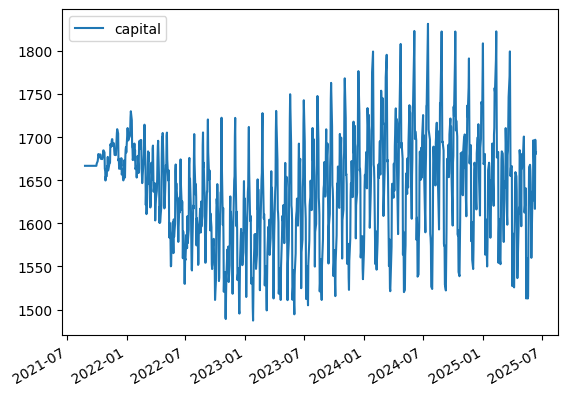

In [ ]:
capital.rolling(5).sum().plot.line()
print(capital[-5:].sum())

### Debug optimal strategy with k=6 max trades per day

In [ ]:
sim_params = SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=4, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1)

res, capital_4trades = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=4, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1)
 Count bids 3738 in total, avg.bids per day 3.9141361256544505,  filled bids 2923, fill bids percent = 0.7819689673622258
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 19, net profit = 889.5967878262063 
  Start capital = 10000, Resulting capital: 16677.573118483917 
  CAGR in 4 years: 1.136 or 13.64 % of avg. growth per year


In [ ]:
filter_stop_loss = (res.lower_entry==1) & (res.stop_loss==1)
print(f'Average real close price if not stop_loss: {res[filter_stop_loss].growth_future_30d.mean()}')
res[filter_stop_loss].head(10)

Average real close price if not stop_loss: nan


,Close_x,Ticker,Date,proba_pred10,pred10_rank,growth_future_30d,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return


In [ ]:
filter_take_profit = (res.lower_entry==1) & (res.take_profit==1) & (res.stop_loss==0)
print(f'Average real close price if not take_profit: {res[filter_take_profit].growth_future_30d.mean()}')
res[filter_take_profit].head(10)

Average real close price if not take_profit: 1.478345851608994


,Close_x,Ticker,Date,proba_pred10,pred10_rank,growth_future_30d,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return
110,20.658768,NVDA,2021-09-28,0.689672,3.0,1.481086,1.516981,0.944732,0.988792,0.149672,0.223213,74.404449,1,0,1,111.606673,-0.148809,111.457865
118,20.675734,NVDA,2021-09-30,0.723713,3.0,1.466982,1.559664,0.943957,0.975236,0.183713,0.233043,77.681033,1,0,1,116.521550,-0.155362,116.366188
123,20.701683,NVDA,2021-10-01,0.728310,4.0,1.465143,1.557709,0.942773,0.942773,0.188310,0.218196,76.422590,1,0,1,114.633885,-0.152845,114.481040
138,21.034035,NVDA,2021-10-07,0.708292,3.0,1.502966,1.533096,0.973238,0.985765,0.168292,0.213761,72.408443,1,0,1,108.612664,-0.144817,108.467847
1173,388.965851,ASML,2022-10-12,0.648440,4.0,1.520519,1.531775,0.911681,0.911681,0.108440,0.212494,77.444848,1,0,1,116.167272,-0.154890,116.012383
1398,14.590031,NVDA,2022-12-29,0.703733,2.0,1.492022,1.576388,0.961035,0.974663,0.163733,0.258188,83.708433,1,0,1,125.562649,-0.167417,125.395232
1745,27.782024,NVDA,2023-05-03,0.671777,1.0,1.534329,1.546811,0.979786,0.979786,0.131777,0.256423,86.076266,1,0,1,129.114399,-0.172153,128.942246
1754,28.659397,NVDA,2023-05-05,0.664825,1.0,1.527634,1.524600,0.966911,0.988494,0.124825,0.373693,161.629045,1,0,1,242.443567,-0.323258,242.120309
1758,29.130056,NVDA,2023-05-08,0.723998,1.0,1.476775,1.509195,0.962094,0.975953,0.183998,0.302973,91.933709,1,0,1,137.900563,-0.183867,137.716696
1769,28.557467,NVDA,2023-05-11,0.688373,3.0,1.421940,1.539455,0.981384,0.981384,0.148373,0.233186,106.196537,1,0,1,159.294805,-0.212393,159.082412


In [ ]:
filter_no_stop_loss_no_take_profit = (res.lower_entry==1) & (res.take_profit==0) & (res.stop_loss==0)
print(f'Average real close price if no take_profit or stop loss: {res[filter_no_stop_loss_no_take_profit].growth_future_30d.mean()}')
res['realised_profit'] = res.future_net_return/res.investment
res[filter_no_stop_loss_no_take_profit][['growth_future_30d','realised_profit']].describe().T

Average real close price if no take_profit or stop loss: 1.0211845244727826


,count,mean,std,min,25%,50%,75%,max
growth_future_30d,2902.0,1.021185,0.102455,0.646606,0.953190,1.017954,1.079636,1.524334
realised_profit,2904.0,1.019170,0.102421,0.644606,0.951219,1.015815,1.077596,1.522334


capital    16677.573118
dtype: float64


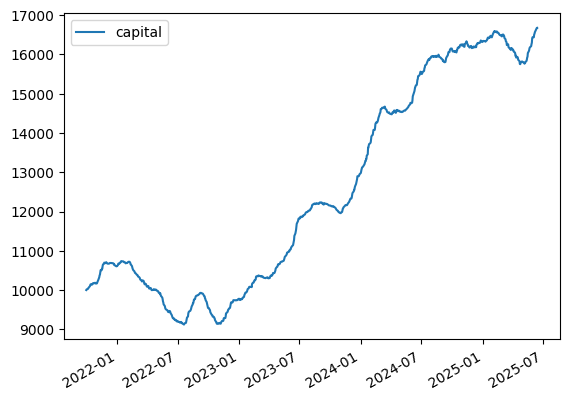

In [ ]:
capital_4trades.rolling(30).sum().plot.line()
print(capital_4trades[-30:].sum())

### Debug optimal strategy with k=1 max trades per day

In [ ]:
sim_params = SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=1, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1.0)

res, capital_1_trade = simulate(new_df, sim_params)

SIMULATION STARTED
Simulations params: SimulationParams(initial_capital=10000, threshold=0.55, fees=0.002, top_k=1, portfolio_optimization=False, stop_loss=0.6, take_profit=1.5, lower_entry=1.0)
 Count bids 955 in total, avg.bids per day 1.0,  filled bids 755, fill bids percent = 0.7905759162303665
  Stop loss events: count = 0, net loss = 0.0 
  Take profit events: count = 5, net profit = 835.6948804896613 
  Start capital = 10000, Resulting capital: 14605.583486772166 
  CAGR in 4 years: 1.099 or 9.93 % of avg. growth per year


In [ ]:
# NO STOP LOSS events
filter_stop_loss = (res.lower_entry==1) & (res.stop_loss==1)
print(f'Average real close price if not stop_loss: {res[filter_stop_loss].growth_future_30d.mean()}')
res[filter_stop_loss].head(10)

Average real close price if not stop_loss: nan


,Close_x,Ticker,Date,proba_pred10,pred10_rank,growth_future_30d,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return,realised_profit


In [ ]:
filter_take_profit = (res.lower_entry==1) & (res.take_profit==1) & (res.stop_loss==0)
print(f'Average real close price if not take_profit: {res[filter_take_profit].growth_future_30d.mean()}')
res[filter_take_profit].head(5)

Average real close price if not take_profit: 1.478345851608994


,Close_x,Ticker,Date,proba_pred10,pred10_rank,growth_future_30d,Ratio_MaxHighNext30_to_Close,Ratio_MinLowNext30_to_Close,Ratio_MinLowNext1_to_Close,weight,weight_norm,investment,lower_entry,stop_loss,take_profit,future_gross_return,fees,future_net_return,realised_profit
110,20.658768,NVDA,2021-09-28,0.689672,3.0,1.481086,1.516981,0.944732,0.988792,0.149672,0.223213,74.404449,1,0,1,111.606673,-0.148809,111.457865,1.498
118,20.675734,NVDA,2021-09-30,0.723713,3.0,1.466982,1.559664,0.943957,0.975236,0.183713,0.233043,77.681033,1,0,1,116.521550,-0.155362,116.366188,1.498
123,20.701683,NVDA,2021-10-01,0.728310,4.0,1.465143,1.557709,0.942773,0.942773,0.188310,0.218196,76.422590,1,0,1,114.633885,-0.152845,114.481040,1.498
138,21.034035,NVDA,2021-10-07,0.708292,3.0,1.502966,1.533096,0.973238,0.985765,0.168292,0.213761,72.408443,1,0,1,108.612664,-0.144817,108.467847,1.498
1173,388.965851,ASML,2022-10-12,0.648440,4.0,1.520519,1.531775,0.911681,0.911681,0.108440,0.212494,77.444848,1,0,1,116.167272,-0.154890,116.012383,1.498


In [ ]:
filter_no_stop_loss_no_take_profit = (res.lower_entry==1) & (res.take_profit==0) & (res.stop_loss==0)
print(f'Average real close price if no take_profit or stop loss: {res[filter_no_stop_loss_no_take_profit].growth_future_30d.mean()}')
res['realised_profit'] = res.future_net_return/res.investment
res[filter_no_stop_loss_no_take_profit][['growth_future_30d','realised_profit']].describe().T

Average real close price if no take_profit or stop loss: 1.0211845244727826


,count,mean,std,min,25%,50%,75%,max
growth_future_30d,2902.0,1.021185,0.102455,0.646606,0.953190,1.017954,1.079636,1.524334
realised_profit,2904.0,1.019170,0.102421,0.644606,0.951219,1.015815,1.077596,1.522334


capital    14605.583487
dtype: float64


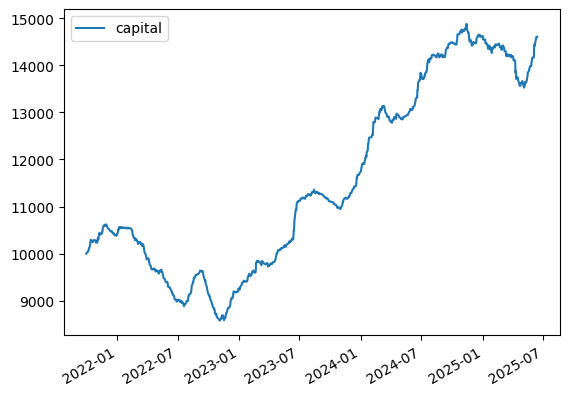

In [ ]:
capital_1_trade.rolling(30).sum().plot.line()
print(capital_1_trade[-30:].sum())

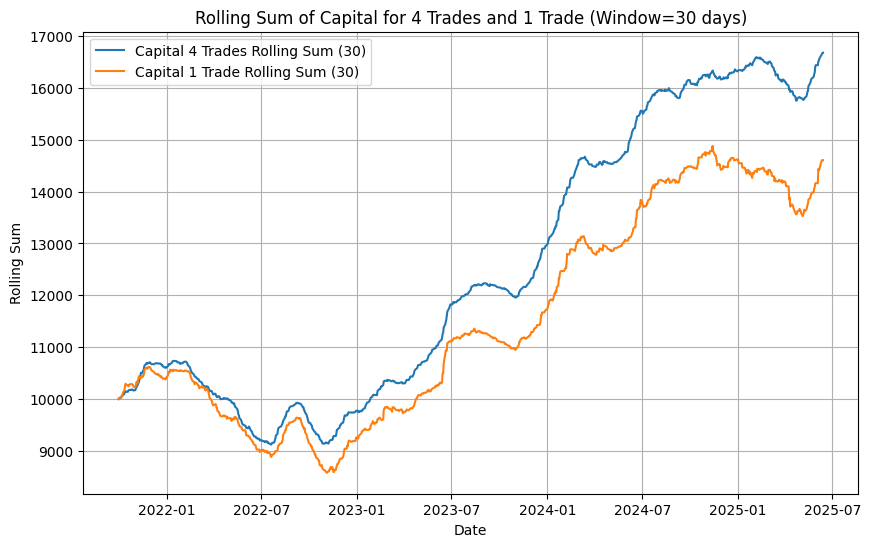

Capital 4 Trades Ending Sum: capital    16677.573118
dtype: float64
Capital 1 Trade Ending Sum: capital    14605.583487
dtype: float64


In [ ]:
import matplotlib.pyplot as plt

# Assuming capital_6trades and capital_1_trade are defined and have the same index
capital_6trades_rolling = capital_6trades.rolling(30).sum()
capital_1_trade_rolling = capital_1_trade.rolling(30).sum()

# Plot the rolling sums on the same graph
plt.figure(figsize=(10, 6))
plt.plot(capital_6trades_rolling, label='Capital 4 Trades Rolling Sum (30)')
plt.plot(capital_1_trade_rolling, label='Capital 1 Trade Rolling Sum (30)')
plt.legend(loc='best')
plt.title('Rolling Sum of Capital for 4 Trades and 1 Trade (Window=30 days)')
plt.xlabel('Date')
plt.ylabel('Rolling Sum')
plt.grid(True)
plt.show()

# Print the ending values
print(f"Capital 4 Trades Ending Sum: {capital_6trades[-30:].sum()}")
print(f"Capital 1 Trade Ending Sum: {capital_1_trade[-30:].sum()}")